# Running a full NEB workflow for migration energy barrier calculations with NEB and MACE

This tutorial shows how to run a vacancy diffusion workflow using the Forge Package. 

The workflow is as follows:
1. Create a random alloy composition
2. Run Monte Carlo to get an energetically favorable order for the structure
3. Relax the alloy structure and it's cell
4. Pick a vacancy index randomly from the structure
5. Sample the nearest and next nearest neighbors of the vacancy
6. Run the vacancy diffusion using the DyNEB method on the vacancy and the target index (picked at random from the nearest neighbors)
7. Relax the vacancy start and end points (handled in the VacancyDiffusion object)
8. Run the NEB simulation 
9. Plot the migration energy barrier


## Loading the necessary packages and modules for FORGE

In [10]:
import numpy as np 

from ase.build import bulk 
from forge.workflows.mcmc import MonteCarloAlloySampler
from mace.calculators.mace import MACECalculator 

# For Step 1, getting the composition we want. 
from forge.analysis.composition import CompositionAnalyzer
from math import ceil, floor

# For checking the device and getting absolute paths
import forge 
import torch
from pathlib import Path


# For creating the vacancy diffusion object in step 4-9
from forge.workflows.neb import VacancyDiffusion

# For plotting the scaled energies
import matplotlib.pyplot as plt

## Creating the composition and initializing the random alloy structure

In [2]:
# set all the seeds
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)


In [3]:
N = 6 # sets the size of the supercell
num_atoms = 2*N**3

# Get the atomic fractions for the alloy correctly rounded to 4 decimal places for the given super cell size
x_zr = round(ceil(0.0025 * num_atoms)/num_atoms, 4)
x_cr = round(ceil(0.03 * num_atoms)/num_atoms, 4)
x_ti = round(ceil(0.04 * num_atoms)/num_atoms, 4)
x_w = round(ceil(0.05 * num_atoms)/num_atoms, 4)
x_v = round(1 - x_zr - x_cr - x_ti - x_w, 4)

# Adjust x_v if the sum of the composition is not 1
if x_zr + x_cr + x_ti + x_w + x_v != 1:
    x_v = 1 - x_zr - x_cr - x_ti - x_w
    
composition = {
    'V' : x_v,
    'Cr' : x_cr,
    'Ti' : x_ti,
    'W' : x_w,
    'Zr' : x_zr
}

print(f"The Composition of our alloy is {composition}")

The Composition of our alloy is {'V': 0.8727, 'Cr': 0.0301, 'Ti': 0.0417, 'W': 0.0509, 'Zr': 0.0046}


Now we will create the randomly ordered alloy structure using the CompositionAnalyzer class. This creates an ASE atoms object. 

In [4]:
analyzer = CompositionAnalyzer()
atoms = analyzer.create_random_alloy(composition = composition, 
                                         crystal_type = 'bcc', 
                                         dimensions=[N,N,N], 
                                         lattice_constant = 3.01,
                                         balance_element = 'V', 
                                         cubic=True)

print(atoms)

Atoms(symbols='Cr14Ti19V375W22Zr2', pbc=True, cell=[18.06, 18.06, 18.06])


## Ordering and then Relaxing the alloy structure and it's cell

For this step, we will load the MACE model we want to use, run the Monte Carlo to get an energetically favorable order for the structure, and then relax the alloy structure and it's cell. 

In [5]:
# The model path should point to your MACE model that you want to use.
model_path = '../potentials/gen_6_model_0_L0_isolated-2026-01-16_stagetwo.model'

# This is some boiler plate code to check the device and enable CUEQ if we are using a GPU.
device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cuda":
    enable_cueq = True
else:
    enable_cueq = False

# Define the mace calculator
calc = MACECalculator(model_paths=[model_path],
                      device=device,
                      default_dtype="float32",
                      enable_cueq=enable_cueq)

# Attach the calculator to the atoms object
atoms.calc = calc

# Define the temperature and the number of steps per atom
temperature = 600+273.15
steps_per_atom = 1 # in this test we do only 1, in real life you want to do 50-100 steps per atom
total_swaps = steps_per_atom * len(atoms)

# Define the Monte Carlo sampler object
mc_sampler = MonteCarloAlloySampler(
    atoms=atoms,
    calculator=calc,
    temperature=temperature,
    steps=total_swaps,
)

# Run the Monte Carlo sampler
final_atoms = mc_sampler.run_mcmc()


/opt/homebrew/Caskroom/miniforge/base/envs/mace/lib/python3.11/site-packages/mace/calculators/mace.py:128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_p

Here we use a wrapper for the ASE relaxation function to relax the structure and it's cell. 

In [6]:
# take in the final atoms and relax the structure 
from forge.workflows.relax import relax 

relaxed_atoms = relax(atoms = final_atoms, 
                     calculator = calc, 
                     relax_cell = True, 
                     fmax = 0.04, 
                     steps = 100, 
                     optimizer = "FIRE",
                     verbose = 0,
                     interval = 0)



## Creating the vacancy diffusion object and running the vacancy diffusion NEB calculation

This step creates the VacancyDiffusion object and runs the vacancy diffusion NEB calculation on a single vacancy and target index. 

In [44]:
# create the VacancyDiffusion object

neb = VacancyDiffusion(atoms = relaxed_atoms,
                       model_path = model_path
                       )



In [45]:
from pathlib import Path

# get the vacancy index randomly from the len of atoms
vac_idx = np.random.randint(0, len(atoms))

print(f"Vacancy index: {vac_idx}")

# get the neighbors of the vacancy index, #TODO separate the nearest and next nearest neighbors results, maybe using a dictionary 
neighbors = neb.sample_neighbors(vacancy_indices=[vac_idx], n_nearest=8, n_next_nearest=1)

# print the neighbors
print(f"Neighbors: {neighbors}")

# get the target index from the neighbors
tar_idx = neighbors[0][1]

print(f"Target index: {tar_idx}")


Vacancy index: 102
Neighbors: [(102, 19), (102, 91), (102, 17), (102, 29), (102, 103), (102, 89), (102, 101), (102, 31), (102, 90)]
Target index: 19


In [46]:
# run the vacancy diffusion
results = neb.run_single(vacancy_index=vac_idx,
               target_index=tar_idx,
               num_images=5,
               neb_method="dyneb",
               climb=True,
               save_xyz=True,
               output_dir=Path(".")
               )

/opt/homebrew/Caskroom/miniforge/base/envs/mace/lib/python3.11/site-packages/mace/calculators/mace.py:128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_p

      Step     Time          Energy          fmax
FIRE:    0 15:31:45    -3940.856445        0.438320
FIRE:    1 15:31:45    -3940.868652        0.420001
FIRE:    2 15:31:46    -3940.891602        0.385125
FIRE:    3 15:31:47    -3940.919434        0.336982
FIRE:    4 15:31:48    -3940.945801        0.280060
FIRE:    5 15:31:50    -3940.966797        0.221654
FIRE:    6 15:31:51    -3940.979492        0.187095
FIRE:    7 15:31:52    -3940.991699        0.150568
FIRE:    8 15:31:53    -3940.998047        0.148041
FIRE:    9 15:31:54    -3941.005371        0.138817
FIRE:   10 15:31:54    -3941.010254        0.162648
FIRE:   11 15:31:55    -3941.014648        0.209600
FIRE:   12 15:31:56    -3941.015625        0.203700
FIRE:   13 15:31:56    -3941.018555        0.192136
FIRE:   14 15:31:57    -3941.021973        0.175383
FIRE:   15 15:31:57    -3941.023438        0.154104
FIRE:   16 15:31:58    -3941.028320        0.129161
FIRE:   17 15:31:59    -3941.029297        0.101588
FIRE:   18 15:

/opt/homebrew/Caskroom/miniforge/base/envs/mace/lib/python3.11/site-packages/mace/calculators/mace.py:128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_p

      Step     Time          Energy          fmax
FIRE:    0 15:32:10    -3941.067383        0.766821
FIRE:    1 15:32:10    -3941.091797        0.716991
FIRE:    2 15:32:11    -3941.135742        0.659170
FIRE:    3 15:32:12    -3941.191406        0.604567
FIRE:    4 15:32:12    -3941.250488        0.538756
FIRE:    5 15:32:13    -3941.304199        0.462198
FIRE:    6 15:32:13    -3941.349121        0.372946
FIRE:    7 15:32:14    -3941.380371        0.270329
FIRE:    8 15:32:15    -3941.400391        0.192766
FIRE:    9 15:32:15    -3941.408691        0.241210
FIRE:   10 15:32:16    -3941.409180        0.234323
FIRE:   11 15:32:16    -3941.410156        0.220743
FIRE:   12 15:32:17    -3941.416016        0.201174
FIRE:   13 15:32:17    -3941.419922        0.180107
FIRE:   14 15:32:18    -3941.425781        0.155351
FIRE:   15 15:32:18    -3941.429688        0.127934
FIRE:   16 15:32:19    -3941.434570        0.099146
FIRE:   17 15:32:20    -3941.438477        0.083122
FIRE:   18 15:

/opt/homebrew/Caskroom/miniforge/base/envs/mace/lib/python3.11/site-packages/mace/calculators/mace.py:128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_p

      Step     Time          Energy          fmax
FIRE:    0 15:32:45    -3939.788574        1.833366
FIRE:    1 15:32:48    -3939.880371        1.481022
FIRE:    2 15:32:51    -3940.016113        1.110751
FIRE:    3 15:32:53    -3940.132812        0.721057
FIRE:    4 15:32:56    -3940.195801        0.394750
FIRE:    5 15:32:59    -3940.211426        0.698655
FIRE:    6 15:33:01    -3940.207520        0.808282
FIRE:    7 15:33:04    -3940.212891        0.779367
FIRE:    8 15:33:07    -3940.219238        0.722558
FIRE:    9 15:33:10    -3940.229980        0.639917
FIRE:   10 15:33:12    -3940.242676        0.534530
FIRE:   11 15:33:15    -3940.251953        0.410625
FIRE:   12 15:33:18    -3940.262207        0.273816
FIRE:   13 15:33:20    -3940.269043        0.231196
FIRE:   14 15:33:23    -3940.273926        0.220954
FIRE:   15 15:33:26    -3940.274902        0.211873
FIRE:   16 15:33:29    -3940.271973        0.289038
FIRE:   17 15:33:32    -3940.270996        0.354046
FIRE:   18 15:

In [30]:
# here is the output of the single vacancy diffusion calculation
results

{'vacancy_element': 'V',
 'target_element': 'W',
 'vacancy_index': '102',
 'target_index': '101',
 'barrier': 0.819580078125,
 'energies': [-3941.60546875,
  -3941.510986328125,
  -3941.022705078125,
  -3940.785888671875,
  -3940.919677734375,
  -3941.236572265625,
  -3941.342529296875],
 'converged': False,
 'n_steps': 200,
 'success': True,
 'error': None,
 'is_nearest_neighbor': True}

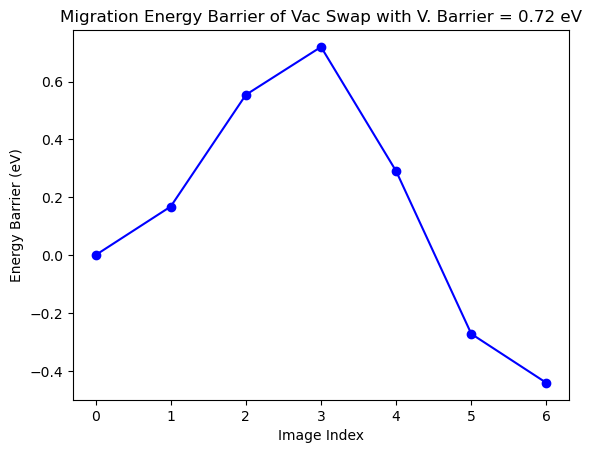

In [47]:
# Here we plot the relative energies of the vacancy diffusion calculation 
scaled_energies = [results['energies'][i] - results['energies'][0] for i in range(len(results['energies']))]

# plot the scaled energies
plt.plot(scaled_energies, marker='o', linestyle='-', color='b')
plt.xlabel('Image Index')
plt.ylabel('Energy Barrier (eV)')
plt.title(f'Migration Energy Barrier of Vac Swap with {results["target_element"]}. Barrier = {round(results["barrier"], 3)} eV')
plt.show()


## Running multiple vacancy diffusion calculations

For most vacancy diffusion calculations, you will want to run multiple vacancy diffusion calculations to infer the compositions potential energy landscape. Caution, this is best done on a GPU.

In [7]:
multi_neb = VacancyDiffusion(atoms=relaxed_atoms, model_path=model_path)

In [8]:
# pick 3 vacancy indices randomly from the len of atoms
multi_vac_indices = np.random.randint(0, len(atoms), 3)

print(f"Vacancy indices: {multi_vac_indices}")

Vacancy indices: [102 348 270]


In [11]:
multi_neb_results = multi_neb.run_multiple(vacancy_indices=multi_vac_indices, 
                       num_images=5, 
                       neb_method='dyneb',
                       climb=True,
                       save_xyz=True,
                       output_dir=Path("./multi_vac_diff_results/"),
                       relax_fmax=0.01,
                       relax_steps=200,
                       neb_fmax=0.05,
                       neb_steps=200,
                       rng_seed=seed
                       )



Starting 42 NEB calculations...


/opt/homebrew/Caskroom/miniforge/base/envs/mace/lib/python3.11/site-packages/mace/calculators/mace.py:128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_p

      Step     Time          Energy          fmax
FIRE:    0 16:26:30    -3941.007324        0.692459
FIRE:    1 16:26:31    -3941.028320        0.678389
FIRE:    2 16:26:31    -3941.067627        0.651009
FIRE:    3 16:26:32    -3941.120361        0.611337
FIRE:    4 16:26:32    -3941.175049        0.559792
FIRE:    5 16:26:33    -3941.228271        0.495358
FIRE:    6 16:26:34    -3941.273682        0.415651
FIRE:    7 16:26:34    -3941.307861        0.318694
FIRE:    8 16:26:35    -3941.328369        0.194057
FIRE:    9 16:26:36    -3941.337402        0.197563
FIRE:   10 16:26:36    -3941.337891        0.194195
FIRE:   11 16:26:37    -3941.340820        0.187571
FIRE:   12 16:26:38    -3941.342285        0.177868
FIRE:   13 16:26:38    -3941.346924        0.165367
FIRE:   14 16:26:39    -3941.351318        0.150440
FIRE:   15 16:26:40    -3941.353271        0.133518
FIRE:   16 16:26:41    -3941.359375        0.115132
FIRE:   17 16:26:41    -3941.363037        0.107068
FIRE:   18 16:

/opt/homebrew/Caskroom/miniforge/base/envs/mace/lib/python3.11/site-packages/mace/calculators/mace.py:128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_p

      Step     Time          Energy          fmax
FIRE:    0 16:27:01    -3940.756104        1.056289
FIRE:    1 16:27:02    -3940.807129        1.005210
FIRE:    2 16:27:03    -3940.898193        0.914375
FIRE:    3 16:27:03    -3941.013916        0.801175
FIRE:    4 16:27:04    -3941.133545        0.680005
FIRE:    5 16:27:05    -3941.244629        0.555268
FIRE:    6 16:27:06    -3941.339600        0.421921
FIRE:    7 16:27:06    -3941.412842        0.399527
FIRE:    8 16:27:07    -3941.468018        0.386945
FIRE:    9 16:27:07    -3941.486816        0.350118
FIRE:   10 16:27:08    -3941.489990        0.338630
FIRE:   11 16:27:09    -3941.496826        0.316164
FIRE:   12 16:27:09    -3941.503418        0.283677
FIRE:   13 16:27:10    -3941.512939        0.242585
FIRE:   14 16:27:10    -3941.522949        0.194633
FIRE:   15 16:27:11    -3941.531250        0.147850
FIRE:   16 16:27:12    -3941.538086        0.110649
FIRE:   17 16:27:12    -3941.543213        0.085745
FIRE:   18 16:

/opt/homebrew/Caskroom/miniforge/base/envs/mace/lib/python3.11/site-packages/mace/calculators/mace.py:128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_p

      Step     Time          Energy          fmax
FIRE:    0 16:27:35    -3941.149414        0.410028
FIRE:    1 16:27:38    -3941.158936        0.368901
FIRE:    2 16:27:42    -3941.174805        0.292293
FIRE:    3 16:27:44    -3941.191895        0.217470
FIRE:    4 16:27:47    -3941.205322        0.188714
FIRE:    5 16:27:50    -3941.213379        0.153375
FIRE:    6 16:27:53    -3941.216553        0.123712
FIRE:    7 16:27:56    -3941.215332        0.168635
FIRE:    8 16:27:59    -3941.217773        0.177078
FIRE:    9 16:28:03    -3941.220703        0.158979
FIRE:   10 16:28:06    -3941.225586        0.128447
FIRE:   11 16:28:08    -3941.227295        0.080230
FIRE:   12 16:28:11    -3941.231445        0.081436
FIRE:   13 16:28:15    -3941.233398        0.096948
FIRE:   14 16:28:18    -3941.236572        0.089193
FIRE:   15 16:28:21    -3941.240967        0.079499
FIRE:   16 16:28:24    -3941.242920        0.073129
FIRE:   17 16:28:26    -3941.242920        0.067989
FIRE:   18 16:

/opt/homebrew/Caskroom/miniforge/base/envs/mace/lib/python3.11/site-packages/mace/calculators/mace.py:128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_p

      Step     Time          Energy          fmax
FIRE:    0 16:28:34    -3941.007324        0.692459
FIRE:    1 16:28:35    -3941.028320        0.678390
FIRE:    2 16:28:35    -3941.067627        0.651008
FIRE:    3 16:28:36    -3941.120361        0.611337
FIRE:    4 16:28:36    -3941.175293        0.559793
FIRE:    5 16:28:37    -3941.228271        0.495360
FIRE:    6 16:28:38    -3941.273682        0.415650
FIRE:    7 16:28:38    -3941.307861        0.318693
FIRE:    8 16:28:39    -3941.328369        0.194059
FIRE:    9 16:28:40    -3941.337402        0.197561
FIRE:   10 16:28:40    -3941.337646        0.194201
FIRE:   11 16:28:41    -3941.340576        0.187569
FIRE:   12 16:28:42    -3941.342285        0.177866
FIRE:   13 16:28:42    -3941.346924        0.165367
FIRE:   14 16:28:43    -3941.351318        0.150440
FIRE:   15 16:28:43    -3941.353516        0.133516
FIRE:   16 16:28:44    -3941.359131        0.115132
FIRE:   17 16:28:44    -3941.362793        0.107067
FIRE:   18 16:

/opt/homebrew/Caskroom/miniforge/base/envs/mace/lib/python3.11/site-packages/mace/calculators/mace.py:128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_p

      Step     Time          Energy          fmax
FIRE:    0 16:29:01    -3940.736816        0.677781
FIRE:    1 16:29:01    -3940.752686        0.631459
FIRE:    2 16:29:02    -3940.783691        0.543985
FIRE:    3 16:29:02    -3940.819336        0.424662
FIRE:    4 16:29:03    -3940.856445        0.285475
FIRE:    5 16:29:03    -3940.890137        0.207099
FIRE:    6 16:29:04    -3940.910889        0.192664
FIRE:    7 16:29:05    -3940.924072        0.185963
FIRE:    8 16:29:05    -3940.931885        0.179131
FIRE:    9 16:29:06    -3940.933594        0.215480
FIRE:   10 16:29:06    -3940.935791        0.209364
FIRE:   11 16:29:07    -3940.938232        0.197317
FIRE:   12 16:29:07    -3940.941895        0.179720
FIRE:   13 16:29:08    -3940.945312        0.157132
FIRE:   14 16:29:08    -3940.948486        0.130283
FIRE:   15 16:29:09    -3940.951172        0.100101
FIRE:   16 16:29:10    -3940.953613        0.088927
FIRE:   17 16:29:10    -3940.956543        0.077274
FIRE:   18 16:

/opt/homebrew/Caskroom/miniforge/base/envs/mace/lib/python3.11/site-packages/mace/calculators/mace.py:128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_p

      Step     Time          Energy          fmax
FIRE:    0 16:29:33    -3939.965576        1.565346
FIRE:    1 16:29:36    -3940.045898        1.386017
FIRE:    2 16:29:39    -3940.166504        1.107740
FIRE:    3 16:29:43    -3940.274902        0.764049
FIRE:    4 16:29:46    -3940.339355        0.442877
FIRE:    5 16:29:49    -3940.362061        0.605689
FIRE:    6 16:29:52    -3940.363525        0.673025
FIRE:    7 16:29:55    -3940.361084        0.559787
FIRE:    8 16:29:58    -3940.365967        0.540350
FIRE:    9 16:30:01    -3940.373047        0.502115
FIRE:   10 16:30:05    -3940.382568        0.446453
FIRE:   11 16:30:07    -3940.393555        0.375434
FIRE:   12 16:30:10    -3940.402100        0.308563
FIRE:   13 16:30:13    -3940.413818        0.244434
FIRE:   14 16:30:17    -3940.422363        0.173458
FIRE:   15 16:30:21    -3940.428711        0.173906
FIRE:   16 16:30:24    -3940.434326        0.168332
FIRE:   17 16:30:28    -3940.437988        0.178487
FIRE:   18 16:

/opt/homebrew/Caskroom/miniforge/base/envs/mace/lib/python3.11/site-packages/mace/calculators/mace.py:128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_p

      Step     Time          Energy          fmax
FIRE:    0 16:31:25    -3941.007324        0.692459
FIRE:    1 16:31:25    -3941.028320        0.678389
FIRE:    2 16:31:26    -3941.067627        0.651009
FIRE:    3 16:31:27    -3941.120361        0.611337
FIRE:    4 16:31:28    -3941.175049        0.559793
FIRE:    5 16:31:28    -3941.228271        0.495358
FIRE:    6 16:31:29    -3941.273926        0.415650
FIRE:    7 16:31:29    -3941.307861        0.318693
FIRE:    8 16:31:30    -3941.328125        0.194059
FIRE:    9 16:31:31    -3941.337402        0.197561
FIRE:   10 16:31:31    -3941.337646        0.194200
FIRE:   11 16:31:32    -3941.340576        0.187569
FIRE:   12 16:31:33    -3941.342041        0.177867
FIRE:   13 16:31:33    -3941.347168        0.165368
FIRE:   14 16:31:34    -3941.351318        0.150440
FIRE:   15 16:31:35    -3941.353516        0.133517
FIRE:   16 16:31:35    -3941.359375        0.115133
FIRE:   17 16:31:36    -3941.362793        0.107067
FIRE:   18 16:

/opt/homebrew/Caskroom/miniforge/base/envs/mace/lib/python3.11/site-packages/mace/calculators/mace.py:128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_p

      Step     Time          Energy          fmax
FIRE:    0 16:31:56    -3940.799561        0.457249
FIRE:    1 16:31:57    -3940.818848        0.451781
FIRE:    2 16:31:58    -3940.855713        0.440367
FIRE:    3 16:31:58    -3940.903809        0.421745
FIRE:    4 16:31:59    -3940.955078        0.393407
FIRE:    5 16:32:00    -3941.009521        0.351378
FIRE:    6 16:32:00    -3941.053467        0.291023
FIRE:    7 16:32:01    -3941.089111        0.217134
FIRE:    8 16:32:01    -3941.114502        0.179756
FIRE:    9 16:32:02    -3941.125488        0.140259
FIRE:   10 16:32:03    -3941.126465        0.136192
FIRE:   11 16:32:03    -3941.128174        0.128227
FIRE:   12 16:32:04    -3941.131104        0.117935
FIRE:   13 16:32:05    -3941.134033        0.108943
FIRE:   14 16:32:05    -3941.137695        0.098094
FIRE:   15 16:32:06    -3941.138184        0.085599
FIRE:   16 16:32:06    -3941.142822        0.071729
FIRE:   17 16:32:07    -3941.145508        0.057468
FIRE:   18 16:

/opt/homebrew/Caskroom/miniforge/base/envs/mace/lib/python3.11/site-packages/mace/calculators/mace.py:128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_p

      Step     Time          Energy          fmax
FIRE:    0 16:32:35    -3940.234863        1.374753
FIRE:    1 16:32:39    -3940.288818        1.216211
FIRE:    2 16:32:42    -3940.376709        0.940645
FIRE:    3 16:32:45    -3940.464111        0.622747
FIRE:    4 16:32:48    -3940.527832        0.363459
FIRE:    5 16:32:51    -3940.553711        0.285885
FIRE:    6 16:32:54    -3940.556152        0.347079
FIRE:    7 16:32:57    -3940.551514        0.422330
FIRE:    8 16:33:00    -3940.553711        0.411301
FIRE:    9 16:33:03    -3940.558594        0.389519
FIRE:   10 16:33:05    -3940.564941        0.357549
FIRE:   11 16:33:08    -3940.571045        0.316226
FIRE:   12 16:33:11    -3940.580566        0.268408
FIRE:   13 16:33:15    -3940.588135        0.217487
FIRE:   14 16:33:19    -3940.595703        0.161059
FIRE:   15 16:33:24    -3940.601562        0.117504
FIRE:   16 16:33:29    -3940.604980        0.107408
FIRE:   17 16:33:32    -3940.607178        0.093557
FIRE:   18 16:

/opt/homebrew/Caskroom/miniforge/base/envs/mace/lib/python3.11/site-packages/mace/calculators/mace.py:128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_p

      Step     Time          Energy          fmax
FIRE:    0 16:34:26    -3941.007324        0.692459
FIRE:    1 16:34:26    -3941.028320        0.678390
FIRE:    2 16:34:27    -3941.067627        0.651009
FIRE:    3 16:34:27    -3941.120361        0.611338
FIRE:    4 16:34:28    -3941.175049        0.559793
FIRE:    5 16:34:29    -3941.228271        0.495358
FIRE:    6 16:34:29    -3941.273438        0.415651
FIRE:    7 16:34:30    -3941.308105        0.318692
FIRE:    8 16:34:30    -3941.328125        0.194059
FIRE:    9 16:34:31    -3941.337402        0.197565
FIRE:   10 16:34:31    -3941.337646        0.194198
FIRE:   11 16:34:32    -3941.340576        0.187570
FIRE:   12 16:34:33    -3941.342285        0.177868
FIRE:   13 16:34:33    -3941.346924        0.165364
FIRE:   14 16:34:34    -3941.351318        0.150439
FIRE:   15 16:34:34    -3941.353516        0.133516
FIRE:   16 16:34:35    -3941.359131        0.115131
FIRE:   17 16:34:35    -3941.363037        0.107066
FIRE:   18 16:

/opt/homebrew/Caskroom/miniforge/base/envs/mace/lib/python3.11/site-packages/mace/calculators/mace.py:128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_p

      Step     Time          Energy          fmax
FIRE:    0 16:34:54    -3940.703857        0.588955
FIRE:    1 16:34:54    -3940.721436        0.548132
FIRE:    2 16:34:55    -3940.753662        0.470570
FIRE:    3 16:34:55    -3940.797607        0.368604
FIRE:    4 16:34:56    -3940.839600        0.356140
FIRE:    5 16:34:56    -3940.876953        0.335182
FIRE:    6 16:34:57    -3940.907959        0.300794
FIRE:    7 16:34:58    -3940.928711        0.248496
FIRE:    8 16:34:58    -3940.947021        0.195075
FIRE:    9 16:34:59    -3940.958496        0.223366
FIRE:   10 16:34:59    -3940.958252        0.202435
FIRE:   11 16:35:00    -3940.959229        0.195864
FIRE:   12 16:35:00    -3940.960938        0.182993
FIRE:   13 16:35:01    -3940.964600        0.164359
FIRE:   14 16:35:02    -3940.970703        0.140751
FIRE:   15 16:35:02    -3940.974365        0.118958
FIRE:   16 16:35:03    -3940.978027        0.098244
FIRE:   17 16:35:04    -3940.981445        0.076674
FIRE:   18 16:

/opt/homebrew/Caskroom/miniforge/base/envs/mace/lib/python3.11/site-packages/mace/calculators/mace.py:128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_p

      Step     Time          Energy          fmax
FIRE:    0 16:35:25    -3940.385010        1.322684
FIRE:    1 16:35:28    -3940.433105        1.084884
FIRE:    2 16:35:31    -3940.503174        0.677604
FIRE:    3 16:35:33    -3940.566895        0.460382
FIRE:    4 16:35:36    -3940.606201        0.291438
FIRE:    5 16:35:40    -3940.622559        0.520411
FIRE:    6 16:35:42    -3940.624512        0.616800
FIRE:    7 16:35:45    -3940.624268        0.550900
FIRE:    8 16:35:48    -3940.624512        0.355572
FIRE:    9 16:35:51    -3940.627686        0.329675
FIRE:   10 16:35:54    -3940.629395        0.320655
FIRE:   11 16:35:56    -3940.633545        0.303052
FIRE:   12 16:35:59    -3940.639160        0.277978
FIRE:   13 16:36:02    -3940.645508        0.245704
FIRE:   14 16:36:05    -3940.652832        0.207196
FIRE:   15 16:36:08    -3940.660645        0.163708
FIRE:   16 16:36:11    -3940.666748        0.116945
FIRE:   17 16:36:15    -3940.671143        0.098696
FIRE:   18 16:

/opt/homebrew/Caskroom/miniforge/base/envs/mace/lib/python3.11/site-packages/mace/calculators/mace.py:128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_p

      Step     Time          Energy          fmax
FIRE:    0 16:37:00    -3941.007324        0.692459
FIRE:    1 16:37:00    -3941.028320        0.678388
FIRE:    2 16:37:01    -3941.067627        0.651008
FIRE:    3 16:37:01    -3941.120361        0.611338
FIRE:    4 16:37:02    -3941.175293        0.559793
FIRE:    5 16:37:03    -3941.228271        0.495361
FIRE:    6 16:37:03    -3941.273438        0.415650
FIRE:    7 16:37:04    -3941.307861        0.318694
FIRE:    8 16:37:04    -3941.328125        0.194059
FIRE:    9 16:37:05    -3941.337402        0.197562
FIRE:   10 16:37:06    -3941.337402        0.194199
FIRE:   11 16:37:06    -3941.340332        0.187569
FIRE:   12 16:37:07    -3941.342285        0.177869
FIRE:   13 16:37:07    -3941.346924        0.165368
FIRE:   14 16:37:08    -3941.351318        0.150439
FIRE:   15 16:37:08    -3941.353516        0.133519
FIRE:   16 16:37:09    -3941.359131        0.115131
FIRE:   17 16:37:10    -3941.363525        0.107067
FIRE:   18 16:

/opt/homebrew/Caskroom/miniforge/base/envs/mace/lib/python3.11/site-packages/mace/calculators/mace.py:128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_p

      Step     Time          Energy          fmax
FIRE:    0 16:37:28    -3940.830322        0.537275
FIRE:    1 16:37:29    -3940.852783        0.523189
FIRE:    2 16:37:29    -3940.896973        0.494721
FIRE:    3 16:37:30    -3940.952881        0.450891
FIRE:    4 16:37:31    -3941.016113        0.389485
FIRE:    5 16:37:31    -3941.076904        0.324708
FIRE:    6 16:37:32    -3941.128662        0.244902
FIRE:    7 16:37:32    -3941.162598        0.156246
FIRE:    8 16:37:33    -3941.174561        0.128664
FIRE:    9 16:37:34    -3941.175293        0.126394
FIRE:   10 16:37:34    -3941.175049        0.121896
FIRE:   11 16:37:35    -3941.178955        0.115251
FIRE:   12 16:37:35    -3941.181152        0.106584
FIRE:   13 16:37:36    -3941.181641        0.096048
FIRE:   14 16:37:36    -3941.184570        0.083832
FIRE:   15 16:37:37    -3941.185059        0.070158
FIRE:   16 16:37:38    -3941.188232        0.053687
FIRE:   17 16:37:38    -3941.188477        0.034463
FIRE:   18 16:

/opt/homebrew/Caskroom/miniforge/base/envs/mace/lib/python3.11/site-packages/mace/calculators/mace.py:128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_p

      Step     Time          Energy          fmax
FIRE:    0 16:37:56    -3940.608398        0.795078
FIRE:    1 16:37:59    -3940.637451        0.703892
FIRE:    2 16:38:02    -3940.684082        0.556643
FIRE:    3 16:38:05    -3940.733887        0.367724
FIRE:    4 16:38:07    -3940.767334        0.213629
FIRE:    5 16:38:10    -3940.782227        0.189201
FIRE:    6 16:38:13    -3940.783203        0.301753
FIRE:    7 16:38:16    -3940.785156        0.292410
FIRE:    8 16:38:19    -3940.787109        0.274021
FIRE:    9 16:38:22    -3940.789307        0.247138
FIRE:   10 16:38:24    -3940.794678        0.212682
FIRE:   11 16:38:27    -3940.797363        0.171869
FIRE:   12 16:38:30    -3940.801270        0.126336
FIRE:   13 16:38:33    -3940.804688        0.086633
FIRE:   14 16:38:36    -3940.807861        0.085555
FIRE:   15 16:38:39    -3940.810059        0.083655
FIRE:   16 16:38:41    -3940.811035        0.090748
FIRE:   17 16:38:43    -3940.812988        0.128595
FIRE:   18 16:

/opt/homebrew/Caskroom/miniforge/base/envs/mace/lib/python3.11/site-packages/mace/calculators/mace.py:128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_p

      Step     Time          Energy          fmax
FIRE:    0 16:39:07    -3941.007324        0.692459
FIRE:    1 16:39:08    -3941.028320        0.678390
FIRE:    2 16:39:09    -3941.067627        0.651009
FIRE:    3 16:39:09    -3941.120361        0.611338
FIRE:    4 16:39:10    -3941.175293        0.559793
FIRE:    5 16:39:10    -3941.228271        0.495359
FIRE:    6 16:39:11    -3941.273682        0.415651
FIRE:    7 16:39:12    -3941.307861        0.318692
FIRE:    8 16:39:12    -3941.328369        0.194059
FIRE:    9 16:39:13    -3941.337402        0.197564
FIRE:   10 16:39:13    -3941.337646        0.194201
FIRE:   11 16:39:14    -3941.340576        0.187570
FIRE:   12 16:39:14    -3941.342285        0.177868
FIRE:   13 16:39:15    -3941.347168        0.165366
FIRE:   14 16:39:16    -3941.351318        0.150441
FIRE:   15 16:39:16    -3941.353516        0.133518
FIRE:   16 16:39:17    -3941.359375        0.115131
FIRE:   17 16:39:17    -3941.363281        0.107067
FIRE:   18 16:

/opt/homebrew/Caskroom/miniforge/base/envs/mace/lib/python3.11/site-packages/mace/calculators/mace.py:128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_p

      Step     Time          Energy          fmax
FIRE:    0 16:39:35    -3940.723145        0.641058
FIRE:    1 16:39:35    -3940.749512        0.596387
FIRE:    2 16:39:36    -3940.800537        0.511864
FIRE:    3 16:39:36    -3940.864502        0.441535
FIRE:    4 16:39:37    -3940.931641        0.379308
FIRE:    5 16:39:38    -3940.990479        0.308637
FIRE:    6 16:39:38    -3941.032471        0.252777
FIRE:    7 16:39:39    -3941.054688        0.174516
FIRE:    8 16:39:40    -3941.059082        0.260056
FIRE:    9 16:39:41    -3941.060791        0.252816
FIRE:   10 16:39:41    -3941.060547        0.238576
FIRE:   11 16:39:42    -3941.062744        0.217806
FIRE:   12 16:39:42    -3941.065430        0.191225
FIRE:   13 16:39:43    -3941.070068        0.159778
FIRE:   14 16:39:43    -3941.073975        0.124649
FIRE:   15 16:39:44    -3941.078613        0.087383
FIRE:   16 16:39:44    -3941.078857        0.054478
FIRE:   17 16:39:45    -3941.080811        0.046707
FIRE:   18 16:

/opt/homebrew/Caskroom/miniforge/base/envs/mace/lib/python3.11/site-packages/mace/calculators/mace.py:128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_p

      Step     Time          Energy          fmax
FIRE:    0 16:40:01    -3940.493652        1.146904
FIRE:    1 16:40:04    -3940.538086        0.944843
FIRE:    2 16:40:07    -3940.605957        0.593722
FIRE:    3 16:40:10    -3940.671143        0.387454
FIRE:    4 16:40:12    -3940.710693        0.269748
FIRE:    5 16:40:16    -3940.725586        0.497555
FIRE:    6 16:40:19    -3940.723877        0.566663
FIRE:    7 16:40:22    -3940.722412        0.471335
FIRE:    8 16:40:25    -3940.724121        0.454819
FIRE:    9 16:40:28    -3940.729248        0.423242
FIRE:   10 16:40:31    -3940.733643        0.377292
FIRE:   11 16:40:34    -3940.740234        0.318693
FIRE:   12 16:40:38    -3940.745361        0.249809
FIRE:   13 16:40:42    -3940.752197        0.193999
FIRE:   14 16:40:44    -3940.757080        0.196324
FIRE:   15 16:40:47    -3940.761719        0.197273
FIRE:   16 16:40:50    -3940.763428        0.195389
FIRE:   17 16:40:52    -3940.762207        0.188948
FIRE:   18 16:

/opt/homebrew/Caskroom/miniforge/base/envs/mace/lib/python3.11/site-packages/mace/calculators/mace.py:128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_p

      Step     Time          Energy          fmax
FIRE:    0 16:41:59    -3941.007324        0.692459
FIRE:    1 16:42:00    -3941.028320        0.678390
FIRE:    2 16:42:00    -3941.067627        0.651009
FIRE:    3 16:42:01    -3941.120361        0.611337
FIRE:    4 16:42:02    -3941.175293        0.559792
FIRE:    5 16:42:02    -3941.228271        0.495357
FIRE:    6 16:42:03    -3941.273438        0.415650
FIRE:    7 16:42:03    -3941.307861        0.318695
FIRE:    8 16:42:04    -3941.328369        0.194059
FIRE:    9 16:42:05    -3941.337402        0.197563
FIRE:   10 16:42:05    -3941.337402        0.194197
FIRE:   11 16:42:06    -3941.340576        0.187569
FIRE:   12 16:42:06    -3941.342285        0.177868
FIRE:   13 16:42:07    -3941.347168        0.165365
FIRE:   14 16:42:07    -3941.351318        0.150440
FIRE:   15 16:42:08    -3941.353516        0.133518
FIRE:   16 16:42:08    -3941.359131        0.115131
FIRE:   17 16:42:09    -3941.363037        0.107068
FIRE:   18 16:

/opt/homebrew/Caskroom/miniforge/base/envs/mace/lib/python3.11/site-packages/mace/calculators/mace.py:128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_p

      Step     Time          Energy          fmax
FIRE:    0 16:42:27    -3940.732666        0.703181
FIRE:    1 16:42:28    -3940.753418        0.655965
FIRE:    2 16:42:29    -3940.790039        0.566603
FIRE:    3 16:42:29    -3940.838623        0.444096
FIRE:    4 16:42:30    -3940.886963        0.299945
FIRE:    5 16:42:30    -3940.931641        0.276185
FIRE:    6 16:42:31    -3940.968994        0.254240
FIRE:    7 16:42:31    -3940.991455        0.218624
FIRE:    8 16:42:32    -3941.008789        0.223689
FIRE:    9 16:42:33    -3941.015869        0.272065
FIRE:   10 16:42:33    -3941.017578        0.264249
FIRE:   11 16:42:34    -3941.020020        0.248863
FIRE:   12 16:42:34    -3941.024170        0.226438
FIRE:   13 16:42:35    -3941.028564        0.197712
FIRE:   14 16:42:35    -3941.031982        0.163724
FIRE:   15 16:42:36    -3941.037109        0.125727
FIRE:   16 16:42:36    -3941.039551        0.085342
FIRE:   17 16:42:37    -3941.041504        0.051355
FIRE:   18 16:

/opt/homebrew/Caskroom/miniforge/base/envs/mace/lib/python3.11/site-packages/mace/calculators/mace.py:128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_p

      Step     Time          Energy          fmax
FIRE:    0 16:42:56    -3940.296387        1.283820
FIRE:    1 16:42:59    -3940.343750        1.141547
FIRE:    2 16:43:02    -3940.417480        0.892964
FIRE:    3 16:43:05    -3940.493408        0.603091
FIRE:    4 16:43:08    -3940.549072        0.359688
FIRE:    5 16:43:11    -3940.576904        0.272627
FIRE:    6 16:43:14    -3940.579102        0.319052
FIRE:    7 16:43:17    -3940.576172        0.382602
FIRE:    8 16:43:20    -3940.577393        0.372418
FIRE:    9 16:43:22    -3940.582275        0.352309
FIRE:   10 16:43:25    -3940.586670        0.322808
FIRE:   11 16:43:28    -3940.593750        0.287183
FIRE:   12 16:43:31    -3940.600830        0.245496
FIRE:   13 16:43:34    -3940.607178        0.197498
FIRE:   14 16:43:36    -3940.613281        0.155528
FIRE:   15 16:43:39    -3940.618408        0.148831
FIRE:   16 16:43:42    -3940.622314        0.138860
FIRE:   17 16:43:45    -3940.623779        0.126577
FIRE:   18 16:

/opt/homebrew/Caskroom/miniforge/base/envs/mace/lib/python3.11/site-packages/mace/calculators/mace.py:128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_p

      Step     Time          Energy          fmax
FIRE:    0 16:44:38    -3941.007324        0.692459
FIRE:    1 16:44:39    -3941.028320        0.678390
FIRE:    2 16:44:40    -3941.067627        0.651009
FIRE:    3 16:44:40    -3941.120361        0.611338
FIRE:    4 16:44:41    -3941.175293        0.559791
FIRE:    5 16:44:42    -3941.228271        0.495359
FIRE:    6 16:44:43    -3941.273682        0.415650
FIRE:    7 16:44:44    -3941.307861        0.318694
FIRE:    8 16:44:44    -3941.328125        0.194059
FIRE:    9 16:44:45    -3941.337646        0.197562
FIRE:   10 16:44:45    -3941.337646        0.194199
FIRE:   11 16:44:46    -3941.340576        0.187570
FIRE:   12 16:44:47    -3941.342529        0.177867
FIRE:   13 16:44:47    -3941.347168        0.165367
FIRE:   14 16:44:48    -3941.351318        0.150442
FIRE:   15 16:44:48    -3941.353027        0.133517
FIRE:   16 16:44:49    -3941.359131        0.115130
FIRE:   17 16:44:49    -3941.363281        0.107068
FIRE:   18 16:

/opt/homebrew/Caskroom/miniforge/base/envs/mace/lib/python3.11/site-packages/mace/calculators/mace.py:128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_p

      Step     Time          Energy          fmax
FIRE:    0 16:45:07    -3940.758301        0.664482
FIRE:    1 16:45:07    -3940.780029        0.619622
FIRE:    2 16:45:08    -3940.819824        0.534645
FIRE:    3 16:45:09    -3940.870117        0.417916
FIRE:    4 16:45:09    -3940.923340        0.324987
FIRE:    5 16:45:10    -3940.975098        0.304187
FIRE:    6 16:45:10    -3941.011719        0.269211
FIRE:    7 16:45:11    -3941.036865        0.215383
FIRE:    8 16:45:12    -3941.043945        0.225613
FIRE:    9 16:45:12    -3941.045654        0.219181
FIRE:   10 16:45:13    -3941.047119        0.206509
FIRE:   11 16:45:13    -3941.049805        0.187991
FIRE:   12 16:45:14    -3941.052246        0.164223
FIRE:   13 16:45:14    -3941.053955        0.135992
FIRE:   14 16:45:15    -3941.056641        0.107892
FIRE:   15 16:45:16    -3941.058350        0.099389
FIRE:   16 16:45:17    -3941.060547        0.089040
FIRE:   17 16:45:17    -3941.062012        0.076722
FIRE:   18 16:

/opt/homebrew/Caskroom/miniforge/base/envs/mace/lib/python3.11/site-packages/mace/calculators/mace.py:128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_p

      Step     Time          Energy          fmax
FIRE:    0 16:45:41    -3940.321533        1.419034
FIRE:    1 16:45:44    -3940.377930        1.155554
FIRE:    2 16:45:47    -3940.460693        0.709393
FIRE:    3 16:45:49    -3940.530762        0.453145
FIRE:    4 16:45:52    -3940.573242        0.287385
FIRE:    5 16:45:55    -3940.588379        0.562244
FIRE:    6 16:45:58    -3940.590088        0.650392
FIRE:    7 16:46:00    -3940.592041        0.625880
FIRE:    8 16:46:03    -3940.597168        0.577776
FIRE:    9 16:46:06    -3940.602295        0.507877
FIRE:   10 16:46:09    -3940.610596        0.418921
FIRE:   11 16:46:12    -3940.619141        0.314593
FIRE:   12 16:46:15    -3940.623535        0.199664
FIRE:   13 16:46:18    -3940.630127        0.084653
FIRE:   14 16:46:21    -3940.634033        0.080598
FIRE:   15 16:46:24    -3940.635254        0.175699
FIRE:   16 16:46:26    -3940.636719        0.260878
FIRE:   17 16:46:29    -3940.636230        0.311813
FIRE:   18 16:

/opt/homebrew/Caskroom/miniforge/base/envs/mace/lib/python3.11/site-packages/mace/calculators/mace.py:128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_p

      Step     Time          Energy          fmax
FIRE:    0 16:47:24    -3941.007324        0.692459
FIRE:    1 16:47:25    -3941.028320        0.678389
FIRE:    2 16:47:25    -3941.067627        0.651008
FIRE:    3 16:47:26    -3941.120361        0.611337
FIRE:    4 16:47:26    -3941.175049        0.559791
FIRE:    5 16:47:27    -3941.228027        0.495359
FIRE:    6 16:47:28    -3941.273926        0.415650
FIRE:    7 16:47:28    -3941.307861        0.318694
FIRE:    8 16:47:29    -3941.327881        0.194060
FIRE:    9 16:47:29    -3941.337402        0.197562
FIRE:   10 16:47:30    -3941.337402        0.194199
FIRE:   11 16:47:30    -3941.340332        0.187569
FIRE:   12 16:47:31    -3941.342285        0.177868
FIRE:   13 16:47:31    -3941.346924        0.165364
FIRE:   14 16:47:32    -3941.351318        0.150439
FIRE:   15 16:47:33    -3941.353271        0.133520
FIRE:   16 16:47:33    -3941.359131        0.115131
FIRE:   17 16:47:34    -3941.363037        0.107067
FIRE:   18 16:

/opt/homebrew/Caskroom/miniforge/base/envs/mace/lib/python3.11/site-packages/mace/calculators/mace.py:128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_p

      Step     Time          Energy          fmax
FIRE:    0 16:47:52    -3941.072510        0.760792
FIRE:    1 16:47:53    -3941.103271        0.745930
FIRE:    2 16:47:53    -3941.157471        0.716892
FIRE:    3 16:47:54    -3941.232910        0.674238
FIRE:    4 16:47:54    -3941.312988        0.617323
FIRE:    5 16:47:55    -3941.391602        0.543766
FIRE:    6 16:47:55    -3941.459717        0.450409
FIRE:    7 16:47:56    -3941.505371        0.336243
FIRE:    8 16:47:57    -3941.531494        0.214321
FIRE:    9 16:47:57    -3941.537354        0.282250
FIRE:   10 16:47:58    -3941.540283        0.276778
FIRE:   11 16:47:58    -3941.545654        0.266033
FIRE:   12 16:47:59    -3941.551758        0.250369
FIRE:   13 16:47:59    -3941.558105        0.230365
FIRE:   14 16:48:00    -3941.565918        0.206904
FIRE:   15 16:48:01    -3941.571777        0.182817
FIRE:   16 16:48:01    -3941.581055        0.156585
FIRE:   17 16:48:02    -3941.587646        0.126108
FIRE:   18 16:

/opt/homebrew/Caskroom/miniforge/base/envs/mace/lib/python3.11/site-packages/mace/calculators/mace.py:128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_p

      Step     Time          Energy          fmax
FIRE:    0 16:48:27    -3935.673828       10.326112
FIRE:    1 16:48:30    -3937.119873        6.112913
FIRE:    2 16:48:33    -3938.140869        3.981565
FIRE:    3 16:48:36    -3938.779297        2.584895
FIRE:    4 16:48:38    -3939.134766        1.733662
FIRE:    5 16:48:41    -3939.282959        1.134655
FIRE:    6 16:48:44    -3939.298584        0.843220
FIRE:    7 16:48:47    -3939.263916        1.168556
FIRE:    8 16:48:50    -3939.233643        1.454452
FIRE:    9 16:48:53    -3939.254883        1.395214
FIRE:   10 16:48:55    -3939.293213        1.279484
FIRE:   11 16:48:58    -3939.343018        1.112495
FIRE:   12 16:49:01    -3939.395264        0.901623
FIRE:   13 16:49:04    -3939.445068        0.656308
FIRE:   14 16:49:07    -3939.483887        0.389092
FIRE:   15 16:49:10    -3939.505371        0.229715
FIRE:   16 16:49:13    -3939.511719        0.203574
FIRE:   17 16:49:15    -3939.502441        0.415325
FIRE:   18 16:

/opt/homebrew/Caskroom/miniforge/base/envs/mace/lib/python3.11/site-packages/mace/calculators/mace.py:128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_p

      Step     Time          Energy          fmax
FIRE:    0 16:50:26    -3941.007324        0.692459
FIRE:    1 16:50:26    -3941.028320        0.678390
FIRE:    2 16:50:27    -3941.067627        0.651009
FIRE:    3 16:50:28    -3941.120361        0.611337
FIRE:    4 16:50:28    -3941.175049        0.559792
FIRE:    5 16:50:29    -3941.228027        0.495357
FIRE:    6 16:50:29    -3941.273438        0.415650
FIRE:    7 16:50:30    -3941.307861        0.318694
FIRE:    8 16:50:30    -3941.328369        0.194061
FIRE:    9 16:50:31    -3941.337158        0.197561
FIRE:   10 16:50:31    -3941.337646        0.194200
FIRE:   11 16:50:32    -3941.340576        0.187568
FIRE:   12 16:50:33    -3941.342285        0.177868
FIRE:   13 16:50:33    -3941.346924        0.165366
FIRE:   14 16:50:34    -3941.351318        0.150441
FIRE:   15 16:50:34    -3941.353271        0.133518
FIRE:   16 16:50:35    -3941.359375        0.115132
FIRE:   17 16:50:36    -3941.363281        0.107066
FIRE:   18 16:

/opt/homebrew/Caskroom/miniforge/base/envs/mace/lib/python3.11/site-packages/mace/calculators/mace.py:128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_p

      Step     Time          Energy          fmax
FIRE:    0 16:50:54    -3941.045898        0.653776
FIRE:    1 16:50:54    -3941.069336        0.642195
FIRE:    2 16:50:55    -3941.114502        0.619772
FIRE:    3 16:50:55    -3941.170654        0.587507
FIRE:    4 16:50:56    -3941.235352        0.545870
FIRE:    5 16:50:56    -3941.300049        0.493936
FIRE:    6 16:50:57    -3941.355469        0.429080
FIRE:    7 16:50:58    -3941.397461        0.348434
FIRE:    8 16:50:58    -3941.424805        0.241043
FIRE:    9 16:50:59    -3941.431885        0.174932
FIRE:   10 16:50:59    -3941.433350        0.169542
FIRE:   11 16:51:00    -3941.437500        0.159703
FIRE:   12 16:51:01    -3941.440430        0.152030
FIRE:   13 16:51:01    -3941.444092        0.142190
FIRE:   14 16:51:02    -3941.448730        0.130479
FIRE:   15 16:51:03    -3941.453857        0.128764
FIRE:   16 16:51:04    -3941.458984        0.133360
FIRE:   17 16:51:05    -3941.462402        0.138084
FIRE:   18 16:

/opt/homebrew/Caskroom/miniforge/base/envs/mace/lib/python3.11/site-packages/mace/calculators/mace.py:128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_p

      Step     Time          Energy          fmax
FIRE:    0 16:51:26    -3935.969971        9.511429
FIRE:    1 16:51:30    -3937.245605        5.899363
FIRE:    2 16:51:34    -3938.225830        3.611962
FIRE:    3 16:51:39    -3938.839111        2.393247
FIRE:    4 16:51:42    -3939.177734        1.657361
FIRE:    5 16:51:45    -3939.313721        1.128725
FIRE:    6 16:51:48    -3939.320312        0.869786
FIRE:    7 16:51:51    -3939.274170        1.136570
FIRE:    8 16:51:54    -3939.234863        1.376862
FIRE:    9 16:51:57    -3939.255127        1.320951
FIRE:   10 16:51:59    -3939.292969        1.211786
FIRE:   11 16:52:02    -3939.340820        1.054454
FIRE:   12 16:52:04    -3939.391602        0.858705
FIRE:   13 16:52:07    -3939.438965        0.642857
FIRE:   14 16:52:09    -3939.476318        0.406899
FIRE:   15 16:52:13    -3939.499023        0.255962
FIRE:   16 16:52:18    -3939.507324        0.211038
FIRE:   17 16:52:21    -3939.500488        0.365588
FIRE:   18 16:

/opt/homebrew/Caskroom/miniforge/base/envs/mace/lib/python3.11/site-packages/mace/calculators/mace.py:128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_p

      Step     Time          Energy          fmax
FIRE:    0 16:53:34    -3941.007324        0.692459
FIRE:    1 16:53:34    -3941.028320        0.678390
FIRE:    2 16:53:35    -3941.067627        0.651008
FIRE:    3 16:53:35    -3941.120361        0.611337
FIRE:    4 16:53:36    -3941.175537        0.559793
FIRE:    5 16:53:36    -3941.228027        0.495358
FIRE:    6 16:53:37    -3941.273682        0.415650
FIRE:    7 16:53:37    -3941.307861        0.318693
FIRE:    8 16:53:38    -3941.328369        0.194059
FIRE:    9 16:53:39    -3941.337646        0.197561
FIRE:   10 16:53:39    -3941.337646        0.194197
FIRE:   11 16:53:40    -3941.340576        0.187570
FIRE:   12 16:53:40    -3941.342529        0.177867
FIRE:   13 16:53:41    -3941.347168        0.165367
FIRE:   14 16:53:41    -3941.351318        0.150441
FIRE:   15 16:53:42    -3941.353271        0.133519
FIRE:   16 16:53:42    -3941.358887        0.115132
FIRE:   17 16:53:43    -3941.363037        0.107067
FIRE:   18 16:

/opt/homebrew/Caskroom/miniforge/base/envs/mace/lib/python3.11/site-packages/mace/calculators/mace.py:128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_p

      Step     Time          Energy          fmax
FIRE:    0 16:54:01    -3940.968994        0.708957
FIRE:    1 16:54:02    -3940.990723        0.694364
FIRE:    2 16:54:02    -3941.031006        0.666064
FIRE:    3 16:54:03    -3941.083008        0.625296
FIRE:    4 16:54:03    -3941.140869        0.572825
FIRE:    5 16:54:04    -3941.198730        0.508129
FIRE:    6 16:54:04    -3941.245850        0.429422
FIRE:    7 16:54:05    -3941.285156        0.335624
FIRE:    8 16:54:05    -3941.312744        0.218795
FIRE:    9 16:54:06    -3941.325195        0.182241
FIRE:   10 16:54:07    -3941.326172        0.177027
FIRE:   11 16:54:07    -3941.327637        0.166796
FIRE:   12 16:54:08    -3941.331055        0.154489
FIRE:   13 16:54:08    -3941.334229        0.143807
FIRE:   14 16:54:09    -3941.337891        0.131210
FIRE:   15 16:54:09    -3941.342285        0.117166
FIRE:   16 16:54:10    -3941.345703        0.103174
FIRE:   17 16:54:10    -3941.349365        0.108250
FIRE:   18 16:

/opt/homebrew/Caskroom/miniforge/base/envs/mace/lib/python3.11/site-packages/mace/calculators/mace.py:128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_p

      Step     Time          Energy          fmax
FIRE:    0 16:54:25    -3937.782471        4.261192
FIRE:    1 16:54:28    -3938.334717        3.477052
FIRE:    2 16:54:31    -3939.038574        2.299853
FIRE:    3 16:54:34    -3939.480225        1.378905
FIRE:    4 16:54:36    -3939.702881        0.863146
FIRE:    5 16:54:39    -3939.763428        0.498776
FIRE:    6 16:54:42    -3939.738281        0.914083
FIRE:    7 16:54:45    -3939.748291        0.877506
FIRE:    8 16:54:47    -3939.763672        0.806261
FIRE:    9 16:54:50    -3939.786377        0.704049
FIRE:   10 16:54:52    -3939.812012        0.576200
FIRE:   11 16:54:55    -3939.837646        0.429419
FIRE:   12 16:54:57    -3939.857666        0.290164
FIRE:   13 16:55:00    -3939.874756        0.148252
FIRE:   14 16:55:03    -3939.885010        0.154264
FIRE:   15 16:55:05    -3939.890381        0.210613
FIRE:   16 16:55:08    -3939.888916        0.323412
FIRE:   17 16:55:10    -3939.888184        0.388435
FIRE:   18 16:

/opt/homebrew/Caskroom/miniforge/base/envs/mace/lib/python3.11/site-packages/mace/calculators/mace.py:128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_p

      Step     Time          Energy          fmax
FIRE:    0 16:55:42    -3941.007324        0.692459
FIRE:    1 16:55:43    -3941.028320        0.678390
FIRE:    2 16:55:43    -3941.067383        0.651008
FIRE:    3 16:55:44    -3941.120361        0.611337
FIRE:    4 16:55:44    -3941.175049        0.559792
FIRE:    5 16:55:45    -3941.228271        0.495359
FIRE:    6 16:55:45    -3941.273682        0.415650
FIRE:    7 16:55:46    -3941.307861        0.318694
FIRE:    8 16:55:47    -3941.328125        0.194060
FIRE:    9 16:55:47    -3941.337646        0.197563
FIRE:   10 16:55:48    -3941.337646        0.194197
FIRE:   11 16:55:48    -3941.340576        0.187570
FIRE:   12 16:55:49    -3941.342285        0.177868
FIRE:   13 16:55:49    -3941.347168        0.165364
FIRE:   14 16:55:50    -3941.351562        0.150441
FIRE:   15 16:55:50    -3941.353271        0.133519
FIRE:   16 16:55:51    -3941.359131        0.115131
FIRE:   17 16:55:52    -3941.362793        0.107068
FIRE:   18 16:

/opt/homebrew/Caskroom/miniforge/base/envs/mace/lib/python3.11/site-packages/mace/calculators/mace.py:128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_p

      Step     Time          Energy          fmax
FIRE:    0 16:56:08    -3940.800537        0.385077
FIRE:    1 16:56:08    -3940.819824        0.378590
FIRE:    2 16:56:09    -3940.853760        0.364997
FIRE:    3 16:56:09    -3940.899414        0.342966
FIRE:    4 16:56:10    -3940.948730        0.310286
FIRE:    5 16:56:10    -3940.996338        0.264009
FIRE:    6 16:56:11    -3941.037354        0.209187
FIRE:    7 16:56:11    -3941.064453        0.147546
FIRE:    8 16:56:12    -3941.076904        0.097217
FIRE:    9 16:56:13    -3941.069580        0.127271
FIRE:   10 16:56:13    -3941.069824        0.124478
FIRE:   11 16:56:14    -3941.072510        0.118990
FIRE:   12 16:56:14    -3941.073975        0.110988
FIRE:   13 16:56:15    -3941.076416        0.100744
FIRE:   14 16:56:15    -3941.080322        0.088605
FIRE:   15 16:56:16    -3941.081543        0.074991
FIRE:   16 16:56:16    -3941.084717        0.060673
FIRE:   17 16:56:17    -3941.087158        0.045638
FIRE:   18 16:

/opt/homebrew/Caskroom/miniforge/base/envs/mace/lib/python3.11/site-packages/mace/calculators/mace.py:128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_p

      Step     Time          Energy          fmax
FIRE:    0 16:56:27    -3937.385986        4.347805
FIRE:    1 16:56:30    -3937.974609        3.544226
FIRE:    2 16:56:33    -3938.704834        2.344191
FIRE:    3 16:56:36    -3939.165039        1.364069
FIRE:    4 16:56:38    -3939.394775        0.834582
FIRE:    5 16:56:43    -3939.454590        0.532155
FIRE:    6 16:56:47    -3939.423340        0.985540
FIRE:    7 16:56:51    -3939.435059        0.943363
FIRE:    8 16:56:54    -3939.454590        0.861290
FIRE:    9 16:56:57    -3939.479004        0.743761
FIRE:   10 16:56:59    -3939.507324        0.597054
FIRE:   11 16:57:02    -3939.531738        0.429071
FIRE:   12 16:57:04    -3939.552979        0.249561
FIRE:   13 16:57:07    -3939.567139        0.181431
FIRE:   14 16:57:09    -3939.573975        0.187042
FIRE:   15 16:57:12    -3939.573975        0.288401
FIRE:   16 16:57:15    -3939.570068        0.408830
FIRE:   17 16:57:17    -3939.568359        0.459496
FIRE:   18 16:

/opt/homebrew/Caskroom/miniforge/base/envs/mace/lib/python3.11/site-packages/mace/calculators/mace.py:128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_p

      Step     Time          Energy          fmax
FIRE:    0 16:58:01    -3941.007324        0.692459
FIRE:    1 16:58:01    -3941.028320        0.678389
FIRE:    2 16:58:02    -3941.067627        0.651009
FIRE:    3 16:58:02    -3941.120361        0.611337
FIRE:    4 16:58:03    -3941.175537        0.559793
FIRE:    5 16:58:03    -3941.228271        0.495360
FIRE:    6 16:58:04    -3941.273682        0.415652
FIRE:    7 16:58:04    -3941.307861        0.318693
FIRE:    8 16:58:05    -3941.328125        0.194058
FIRE:    9 16:58:05    -3941.337402        0.197562
FIRE:   10 16:58:06    -3941.337402        0.194199
FIRE:   11 16:58:06    -3941.340576        0.187570
FIRE:   12 16:58:07    -3941.342529        0.177868
FIRE:   13 16:58:07    -3941.346924        0.165367
FIRE:   14 16:58:08    -3941.351318        0.150442
FIRE:   15 16:58:08    -3941.353271        0.133520
FIRE:   16 16:58:09    -3941.359131        0.115130
FIRE:   17 16:58:09    -3941.362793        0.107066
FIRE:   18 16:

/opt/homebrew/Caskroom/miniforge/base/envs/mace/lib/python3.11/site-packages/mace/calculators/mace.py:128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_p

      Step     Time          Energy          fmax
FIRE:    0 16:58:27    -3941.001465        0.661112
FIRE:    1 16:58:27    -3941.025391        0.650066
FIRE:    2 16:58:28    -3941.071777        0.628402
FIRE:    3 16:58:28    -3941.133301        0.596461
FIRE:    4 16:58:29    -3941.200439        0.553663
FIRE:    5 16:58:29    -3941.265625        0.497747
FIRE:    6 16:58:30    -3941.320801        0.424924
FIRE:    7 16:58:30    -3941.363281        0.331925
FIRE:    8 16:58:31    -3941.388672        0.207651
FIRE:    9 16:58:32    -3941.394531        0.229925
FIRE:   10 16:58:32    -3941.395996        0.225791
FIRE:   11 16:58:33    -3941.398926        0.217664
FIRE:   12 16:58:33    -3941.401367        0.205815
FIRE:   13 16:58:34    -3941.406250        0.190659
FIRE:   14 16:58:35    -3941.412109        0.172712
FIRE:   15 16:58:35    -3941.417236        0.152599
FIRE:   16 16:58:36    -3941.422119        0.131041
FIRE:   17 16:58:36    -3941.426270        0.123293
FIRE:   18 16:

/opt/homebrew/Caskroom/miniforge/base/envs/mace/lib/python3.11/site-packages/mace/calculators/mace.py:128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_p

      Step     Time          Energy          fmax
FIRE:    0 16:58:58    -3935.852295        9.526466
FIRE:    1 16:59:01    -3937.120605        5.848660
FIRE:    2 16:59:04    -3938.088867        3.562032
FIRE:    3 16:59:06    -3938.696777        2.371972
FIRE:    4 16:59:09    -3939.032715        1.638613
FIRE:    5 16:59:12    -3939.166992        1.063407
FIRE:    6 16:59:14    -3939.175537        0.804035
FIRE:    7 16:59:17    -3939.131104        1.145423
FIRE:    8 16:59:20    -3939.097900        1.354128
FIRE:    9 16:59:23    -3939.118164        1.299599
FIRE:   10 16:59:25    -3939.157471        1.193180
FIRE:   11 16:59:28    -3939.205811        1.039929
FIRE:   12 16:59:31    -3939.258545        0.851372
FIRE:   13 16:59:33    -3939.307861        0.635463
FIRE:   14 16:59:36    -3939.345947        0.398823
FIRE:   15 16:59:39    -3939.367188        0.232446
FIRE:   16 16:59:42    -3939.374512        0.173044
FIRE:   17 16:59:44    -3939.366943        0.374818
FIRE:   18 16:

/opt/homebrew/Caskroom/miniforge/base/envs/mace/lib/python3.11/site-packages/mace/calculators/mace.py:128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_p

      Step     Time          Energy          fmax
FIRE:    0 17:00:50    -3941.007324        0.692459
FIRE:    1 17:00:51    -3941.028320        0.678389
FIRE:    2 17:00:52    -3941.067627        0.651009
FIRE:    3 17:00:52    -3941.120361        0.611337
FIRE:    4 17:00:53    -3941.175049        0.559792
FIRE:    5 17:00:54    -3941.228271        0.495361
FIRE:    6 17:00:54    -3941.273926        0.415652
FIRE:    7 17:00:55    -3941.307861        0.318695
FIRE:    8 17:00:55    -3941.327881        0.194058
FIRE:    9 17:00:56    -3941.337402        0.197563
FIRE:   10 17:00:57    -3941.337646        0.194199
FIRE:   11 17:00:57    -3941.340576        0.187572
FIRE:   12 17:00:58    -3941.342285        0.177870
FIRE:   13 17:00:58    -3941.347168        0.165365
FIRE:   14 17:00:59    -3941.351318        0.150441
FIRE:   15 17:00:59    -3941.353271        0.133518
FIRE:   16 17:01:00    -3941.359375        0.115129
FIRE:   17 17:01:01    -3941.363281        0.107068
FIRE:   18 17:

/opt/homebrew/Caskroom/miniforge/base/envs/mace/lib/python3.11/site-packages/mace/calculators/mace.py:128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_p

      Step     Time          Energy          fmax
FIRE:    0 17:01:18    -3940.701416        0.514415
FIRE:    1 17:01:18    -3940.722900        0.504976
FIRE:    2 17:01:19    -3940.765869        0.486484
FIRE:    3 17:01:20    -3940.816406        0.459193
FIRE:    4 17:01:20    -3940.873047        0.422332
FIRE:    5 17:01:21    -3940.923340        0.373359
FIRE:    6 17:01:21    -3940.966797        0.308466
FIRE:    7 17:01:22    -3941.002441        0.227189
FIRE:    8 17:01:22    -3941.025391        0.130467
FIRE:    9 17:01:23    -3941.025146        0.166275
FIRE:   10 17:01:23    -3941.027588        0.161237
FIRE:   11 17:01:24    -3941.030762        0.151401
FIRE:   12 17:01:24    -3941.034424        0.137267
FIRE:   13 17:01:25    -3941.036133        0.119585
FIRE:   14 17:01:25    -3941.040039        0.099364
FIRE:   15 17:01:26    -3941.042480        0.077961
FIRE:   16 17:01:26    -3941.043945        0.057280
FIRE:   17 17:01:27    -3941.046143        0.039022
FIRE:   18 17:

/opt/homebrew/Caskroom/miniforge/base/envs/mace/lib/python3.11/site-packages/mace/calculators/mace.py:128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_p

      Step     Time          Energy          fmax
FIRE:    0 17:01:44    -3935.323975        6.976619
FIRE:    1 17:01:48    -3936.793701        4.647290
FIRE:    2 17:01:51    -3937.783691        3.188551
FIRE:    3 17:01:55    -3938.397217        2.094179
FIRE:    4 17:01:57    -3938.724121        1.339868
FIRE:    5 17:02:00    -3938.845947        0.862605
FIRE:    6 17:02:03    -3938.843018        0.939451
FIRE:    7 17:02:06    -3938.795166        1.251174
FIRE:    8 17:02:09    -3938.813721        1.191569
FIRE:    9 17:02:12    -3938.847900        1.075936
FIRE:   10 17:02:14    -3938.893311        0.911202
FIRE:   11 17:02:17    -3938.941162        0.707174
FIRE:   12 17:02:21    -3938.984375        0.476234
FIRE:   13 17:02:23    -3939.018311        0.274813
FIRE:   14 17:02:26    -3939.039795        0.221742
FIRE:   15 17:02:29    -3939.045166        0.237686
FIRE:   16 17:02:32    -3939.039551        0.423887
FIRE:   17 17:02:34    -3939.027100        0.572173
FIRE:   18 17:

/opt/homebrew/Caskroom/miniforge/base/envs/mace/lib/python3.11/site-packages/mace/calculators/mace.py:128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_p

      Step     Time          Energy          fmax
FIRE:    0 17:04:06    -3940.666504        0.521325
FIRE:    1 17:04:07    -3940.683350        0.490063
FIRE:    2 17:04:07    -3940.716553        0.432639
FIRE:    3 17:04:08    -3940.758545        0.361905
FIRE:    4 17:04:08    -3940.799805        0.325827
FIRE:    5 17:04:09    -3940.837402        0.274776
FIRE:    6 17:04:09    -3940.869141        0.205750
FIRE:    7 17:04:10    -3940.892822        0.172088
FIRE:    8 17:04:11    -3940.906006        0.158779
FIRE:    9 17:04:11    -3940.905518        0.183579
FIRE:   10 17:04:12    -3940.906738        0.179349
FIRE:   11 17:04:12    -3940.909912        0.171012
FIRE:   12 17:04:13    -3940.911865        0.158816
FIRE:   13 17:04:13    -3940.915283        0.143133
FIRE:   14 17:04:14    -3940.916260        0.124403
FIRE:   15 17:04:14    -3940.919922        0.103209
FIRE:   16 17:04:15    -3940.922119        0.080161
FIRE:   17 17:04:15    -3940.923584        0.053497
FIRE:   18 17:

/opt/homebrew/Caskroom/miniforge/base/envs/mace/lib/python3.11/site-packages/mace/calculators/mace.py:128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_p

      Step     Time          Energy          fmax
FIRE:    0 17:04:28    -3940.976074        0.610202
FIRE:    1 17:04:29    -3940.998535        0.598212
FIRE:    2 17:04:29    -3941.037354        0.574392
FIRE:    3 17:04:30    -3941.089600        0.538822
FIRE:    4 17:04:30    -3941.144531        0.491161
FIRE:    5 17:04:31    -3941.196289        0.430555
FIRE:    6 17:04:31    -3941.241211        0.356208
FIRE:    7 17:04:32    -3941.271973        0.269055
FIRE:    8 17:04:32    -3941.288574        0.164083
FIRE:    9 17:04:33    -3941.290527        0.187923
FIRE:   10 17:04:33    -3941.291992        0.184869
FIRE:   11 17:04:34    -3941.293457        0.178853
FIRE:   12 17:04:34    -3941.297119        0.170047
FIRE:   13 17:04:35    -3941.299072        0.158708
FIRE:   14 17:04:36    -3941.303711        0.145163
FIRE:   15 17:04:36    -3941.308105        0.129807
FIRE:   16 17:04:37    -3941.309326        0.113131
FIRE:   17 17:04:38    -3941.315186        0.093872
FIRE:   18 17:

/opt/homebrew/Caskroom/miniforge/base/envs/mace/lib/python3.11/site-packages/mace/calculators/mace.py:128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_p

      Step     Time          Energy          fmax
FIRE:    0 17:04:55    -3781.367188      394.825752
FIRE:    1 17:04:57    -3795.197266      357.527327
FIRE:    2 17:05:00    -3842.569092      416.316148
FIRE:    3 17:05:03    -3896.318848      199.965151
FIRE:    4 17:05:05    -3915.232178       60.462933
FIRE:    5 17:05:08    -3919.427734       49.479576
FIRE:    6 17:05:11    -3923.328369       45.208624
FIRE:    7 17:05:13    -3924.425781       38.181897
FIRE:    8 17:05:17    -3925.064941       31.295984
FIRE:    9 17:05:20    -3925.634766       23.087416
FIRE:   10 17:05:23    -3925.355469       24.446231
FIRE:   11 17:05:26    -3924.764404       32.870201
FIRE:   12 17:05:28    -3925.564941       15.825249
FIRE:   13 17:05:31    -3925.107910       15.550425
FIRE:   14 17:05:34    -3924.138184       27.274155
FIRE:   15 17:05:37    -3922.046875       47.823802
FIRE:   16 17:05:40    -3919.706055       64.095878
FIRE:   17 17:05:43    -3917.225098       75.725895
FIRE:   18 17:

/opt/homebrew/Caskroom/miniforge/base/envs/mace/lib/python3.11/site-packages/mace/calculators/mace.py:128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_p

      Step     Time          Energy          fmax
FIRE:    0 17:14:29    -3940.666504        0.521325
FIRE:    1 17:14:29    -3940.683350        0.490062
FIRE:    2 17:14:30    -3940.716553        0.432640
FIRE:    3 17:14:30    -3940.758545        0.361904
FIRE:    4 17:14:31    -3940.799805        0.325827
FIRE:    5 17:14:31    -3940.837402        0.274775
FIRE:    6 17:14:32    -3940.869629        0.205748
FIRE:    7 17:14:32    -3940.892090        0.172086
FIRE:    8 17:14:33    -3940.905762        0.158780
FIRE:    9 17:14:34    -3940.905762        0.183579
FIRE:   10 17:14:34    -3940.906982        0.179350
FIRE:   11 17:14:35    -3940.909912        0.171013
FIRE:   12 17:14:35    -3940.912109        0.158816
FIRE:   13 17:14:36    -3940.915771        0.143132
FIRE:   14 17:14:36    -3940.916260        0.124401
FIRE:   15 17:14:37    -3940.919922        0.103207
FIRE:   16 17:14:37    -3940.922363        0.080160
FIRE:   17 17:14:38    -3940.923584        0.053497
FIRE:   18 17:

/opt/homebrew/Caskroom/miniforge/base/envs/mace/lib/python3.11/site-packages/mace/calculators/mace.py:128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_p

      Step     Time          Energy          fmax
FIRE:    0 17:14:50    -3941.140625        0.561665
FIRE:    1 17:14:50    -3941.165039        0.548707
FIRE:    2 17:14:51    -3941.209229        0.522561
FIRE:    3 17:14:51    -3941.264160        0.482627
FIRE:    4 17:14:52    -3941.325195        0.427797
FIRE:    5 17:14:52    -3941.379150        0.356896
FIRE:    6 17:14:53    -3941.423584        0.270329
FIRE:    7 17:14:53    -3941.455566        0.192029
FIRE:    8 17:14:54    -3941.471924        0.169328
FIRE:    9 17:14:55    -3941.472168        0.175320
FIRE:   10 17:14:55    -3941.473633        0.170408
FIRE:   11 17:14:56    -3941.475586        0.160773
FIRE:   12 17:14:56    -3941.479004        0.146812
FIRE:   13 17:14:57    -3941.481689        0.129157
FIRE:   14 17:14:57    -3941.486816        0.108618
FIRE:   15 17:14:58    -3941.490479        0.092973
FIRE:   16 17:14:58    -3941.492676        0.076744
FIRE:   17 17:14:59    -3941.495850        0.059645
FIRE:   18 17:

/opt/homebrew/Caskroom/miniforge/base/envs/mace/lib/python3.11/site-packages/mace/calculators/mace.py:128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_p

      Step     Time          Energy          fmax
FIRE:    0 17:15:17    -3940.270996        1.062647
FIRE:    1 17:15:20    -3940.323486        0.942787
FIRE:    2 17:15:23    -3940.404297        0.723110
FIRE:    3 17:15:26    -3940.479004        0.458729
FIRE:    4 17:15:29    -3940.523926        0.233730
FIRE:    5 17:15:31    -3940.539062        0.392456
FIRE:    6 17:15:34    -3940.537109        0.463092
FIRE:    7 17:15:37    -3940.539795        0.446679
FIRE:    8 17:15:40    -3940.543945        0.414449
FIRE:    9 17:15:43    -3940.548340        0.367666
FIRE:   10 17:15:46    -3940.556396        0.308205
FIRE:   11 17:15:50    -3940.561768        0.238705
FIRE:   12 17:15:53    -3940.567139        0.170400
FIRE:   13 17:15:55    -3940.573730        0.165370
FIRE:   14 17:15:58    -3940.575928        0.158902
FIRE:   15 17:16:01    -3940.578125        0.150659
FIRE:   16 17:16:03    -3940.578857        0.172545
FIRE:   17 17:16:06    -3940.577881        0.208123
FIRE:   18 17:

/opt/homebrew/Caskroom/miniforge/base/envs/mace/lib/python3.11/site-packages/mace/calculators/mace.py:128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_p

      Step     Time          Energy          fmax
FIRE:    0 17:16:55    -3940.666504        0.521325
FIRE:    1 17:16:56    -3940.683350        0.490062
FIRE:    2 17:16:57    -3940.716553        0.432640
FIRE:    3 17:16:57    -3940.758301        0.361904
FIRE:    4 17:16:58    -3940.799805        0.325827
FIRE:    5 17:16:58    -3940.837402        0.274775
FIRE:    6 17:16:59    -3940.869141        0.205748
FIRE:    7 17:16:59    -3940.892334        0.172088
FIRE:    8 17:17:00    -3940.906006        0.158782
FIRE:    9 17:17:01    -3940.905518        0.183581
FIRE:   10 17:17:01    -3940.906982        0.179350
FIRE:   11 17:17:02    -3940.909912        0.171013
FIRE:   12 17:17:02    -3940.911865        0.158815
FIRE:   13 17:17:03    -3940.915283        0.143133
FIRE:   14 17:17:03    -3940.916260        0.124402
FIRE:   15 17:17:04    -3940.919922        0.103202
FIRE:   16 17:17:04    -3940.922119        0.080161
FIRE:   17 17:17:05    -3940.923828        0.053500
FIRE:   18 17:

/opt/homebrew/Caskroom/miniforge/base/envs/mace/lib/python3.11/site-packages/mace/calculators/mace.py:128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_p

      Step     Time          Energy          fmax
FIRE:    0 17:17:16    -3940.598877        0.391174
FIRE:    1 17:17:17    -3940.614746        0.383311
FIRE:    2 17:17:18    -3940.643555        0.367268
FIRE:    3 17:17:18    -3940.678467        0.342233
FIRE:    4 17:17:19    -3940.716309        0.306779
FIRE:    5 17:17:19    -3940.751709        0.259261
FIRE:    6 17:17:20    -3940.781738        0.199286
FIRE:    7 17:17:20    -3940.804199        0.179784
FIRE:    8 17:17:21    -3940.816406        0.151781
FIRE:    9 17:17:21    -3940.822021        0.113049
FIRE:   10 17:17:22    -3940.823730        0.111031
FIRE:   11 17:17:22    -3940.823730        0.107348
FIRE:   12 17:17:23    -3940.826904        0.102398
FIRE:   13 17:17:23    -3940.829346        0.096246
FIRE:   14 17:17:24    -3940.832031        0.089259
FIRE:   15 17:17:25    -3940.833740        0.081867
FIRE:   16 17:17:25    -3940.836426        0.074521
FIRE:   17 17:17:26    -3940.837158        0.066978
FIRE:   18 17:

/opt/homebrew/Caskroom/miniforge/base/envs/mace/lib/python3.11/site-packages/mace/calculators/mace.py:128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_p

      Step     Time          Energy          fmax
FIRE:    0 17:17:44    -3786.025635      358.973793
FIRE:    1 17:17:47    -3823.912598      415.273604
FIRE:    2 17:17:51    -3879.757812      294.163964
FIRE:    3 17:17:56    -3910.035645      101.243524
FIRE:    4 17:18:01    -3914.506836       54.338704
FIRE:    5 17:18:05    -3919.121582       49.495971
FIRE:    6 17:18:08    -3922.916016       49.869064
FIRE:    7 17:18:10    -3923.271729       43.782964
FIRE:    8 17:18:13    -3923.943848       33.704464
FIRE:    9 17:18:16    -3924.714844       23.430332
FIRE:   10 17:18:19    -3925.119385       14.438782
FIRE:   11 17:18:21    -3924.530762       26.837036
FIRE:   12 17:18:24    -3923.818604       30.246100
FIRE:   13 17:18:27    -3922.462891       37.220522
FIRE:   14 17:18:30    -3920.491699       48.642855
FIRE:   15 17:18:32    -3917.868896       65.326405
FIRE:   16 17:18:35    -3914.784912       82.863044
FIRE:   17 17:18:39    -3911.703125      101.268885
FIRE:   18 17:

/opt/homebrew/Caskroom/miniforge/base/envs/mace/lib/python3.11/site-packages/mace/calculators/mace.py:128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_p

      Step     Time          Energy          fmax
FIRE:    0 17:27:13    -3940.666504        0.521325
FIRE:    1 17:27:14    -3940.683350        0.490062
FIRE:    2 17:27:14    -3940.716553        0.432640
FIRE:    3 17:27:15    -3940.758301        0.361904
FIRE:    4 17:27:15    -3940.799805        0.325827
FIRE:    5 17:27:16    -3940.837646        0.274776
FIRE:    6 17:27:16    -3940.869385        0.205748
FIRE:    7 17:27:17    -3940.892578        0.172088
FIRE:    8 17:27:17    -3940.906006        0.158781
FIRE:    9 17:27:18    -3940.905518        0.183580
FIRE:   10 17:27:19    -3940.906982        0.179352
FIRE:   11 17:27:19    -3940.909912        0.171013
FIRE:   12 17:27:20    -3940.911621        0.158816
FIRE:   13 17:27:20    -3940.915527        0.143132
FIRE:   14 17:27:21    -3940.916260        0.124401
FIRE:   15 17:27:21    -3940.919922        0.103202
FIRE:   16 17:27:22    -3940.922363        0.080162
FIRE:   17 17:27:23    -3940.923584        0.053499
FIRE:   18 17:

/opt/homebrew/Caskroom/miniforge/base/envs/mace/lib/python3.11/site-packages/mace/calculators/mace.py:128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_p

      Step     Time          Energy          fmax
FIRE:    0 17:27:34    -3941.171387        0.966597
FIRE:    1 17:27:35    -3941.211670        0.862748
FIRE:    2 17:27:36    -3941.281250        0.677228
FIRE:    3 17:27:36    -3941.365234        0.608050
FIRE:    4 17:27:37    -3941.450439        0.517981
FIRE:    5 17:27:37    -3941.527100        0.422880
FIRE:    6 17:27:38    -3941.586914        0.327157
FIRE:    7 17:27:39    -3941.626709        0.366640
FIRE:    8 17:27:40    -3941.645020        0.413035
FIRE:    9 17:27:41    -3941.646729        0.401208
FIRE:   10 17:27:42    -3941.649170        0.377864
FIRE:   11 17:27:42    -3941.654297        0.343677
FIRE:   12 17:27:43    -3941.659424        0.299670
FIRE:   13 17:27:43    -3941.663818        0.247309
FIRE:   14 17:27:44    -3941.667725        0.188533
FIRE:   15 17:27:44    -3941.670654        0.126123
FIRE:   16 17:27:45    -3941.675781        0.066161
FIRE:   17 17:27:45    -3941.677490        0.062654
FIRE:   18 17:

/opt/homebrew/Caskroom/miniforge/base/envs/mace/lib/python3.11/site-packages/mace/calculators/mace.py:128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_p

      Step     Time          Energy          fmax
FIRE:    0 17:28:08    -3940.116455        1.435462
FIRE:    1 17:28:11    -3940.189941        1.219754
FIRE:    2 17:28:13    -3940.296631        0.811115
FIRE:    3 17:28:16    -3940.381104        0.405984
FIRE:    4 17:28:19    -3940.426025        0.356761
FIRE:    5 17:28:22    -3940.431641        0.482950
FIRE:    6 17:28:25    -3940.417969        0.618108
FIRE:    7 17:28:27    -3940.421875        0.597055
FIRE:    8 17:28:31    -3940.428711        0.555630
FIRE:    9 17:28:34    -3940.437012        0.500120
FIRE:   10 17:28:37    -3940.445557        0.429275
FIRE:   11 17:28:40    -3940.453369        0.345488
FIRE:   12 17:28:43    -3940.461426        0.252151
FIRE:   13 17:28:46    -3940.466309        0.210672
FIRE:   14 17:28:48    -3940.470215        0.188754
FIRE:   15 17:28:53    -3940.468994        0.171130
FIRE:   16 17:28:57    -3940.467041        0.224386
FIRE:   17 17:29:00    -3940.464844        0.292091
FIRE:   18 17:

/opt/homebrew/Caskroom/miniforge/base/envs/mace/lib/python3.11/site-packages/mace/calculators/mace.py:128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_p

      Step     Time          Energy          fmax
FIRE:    0 17:29:54    -3940.666504        0.521325
FIRE:    1 17:29:55    -3940.683350        0.490062
FIRE:    2 17:29:56    -3940.716553        0.432639
FIRE:    3 17:29:56    -3940.758545        0.361904
FIRE:    4 17:29:57    -3940.799805        0.325827
FIRE:    5 17:29:57    -3940.837402        0.274776
FIRE:    6 17:29:58    -3940.869385        0.205748
FIRE:    7 17:29:58    -3940.892578        0.172089
FIRE:    8 17:29:59    -3940.906006        0.158781
FIRE:    9 17:30:00    -3940.905518        0.183582
FIRE:   10 17:30:00    -3940.906982        0.179349
FIRE:   11 17:30:01    -3940.909912        0.171014
FIRE:   12 17:30:01    -3940.912109        0.158814
FIRE:   13 17:30:02    -3940.915527        0.143134
FIRE:   14 17:30:03    -3940.916504        0.124402
FIRE:   15 17:30:03    -3940.919922        0.103209
FIRE:   16 17:30:04    -3940.922119        0.080166
FIRE:   17 17:30:04    -3940.923828        0.053499
FIRE:   18 17:

/opt/homebrew/Caskroom/miniforge/base/envs/mace/lib/python3.11/site-packages/mace/calculators/mace.py:128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_p

      Step     Time          Energy          fmax
FIRE:    0 17:30:16    -3940.657227        0.441555
FIRE:    1 17:30:16    -3940.671631        0.432910
FIRE:    2 17:30:17    -3940.691895        0.415812
FIRE:    3 17:30:18    -3940.723877        0.390431
FIRE:    4 17:30:18    -3940.754639        0.356628
FIRE:    5 17:30:19    -3940.784912        0.313816
FIRE:    6 17:30:19    -3940.808838        0.261410
FIRE:    7 17:30:20    -3940.825439        0.200362
FIRE:    8 17:30:21    -3940.838623        0.129886
FIRE:    9 17:30:21    -3940.838135        0.121522
FIRE:   10 17:30:22    -3940.838867        0.119483
FIRE:   11 17:30:22    -3940.840332        0.115455
FIRE:   12 17:30:23    -3940.841553        0.109544
FIRE:   13 17:30:23    -3940.843506        0.101918
FIRE:   14 17:30:24    -3940.844727        0.092777
FIRE:   15 17:30:24    -3940.848145        0.082375
FIRE:   16 17:30:25    -3940.849854        0.071026
FIRE:   17 17:30:25    -3940.850830        0.057855
FIRE:   18 17:

/opt/homebrew/Caskroom/miniforge/base/envs/mace/lib/python3.11/site-packages/mace/calculators/mace.py:128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_p

      Step     Time          Energy          fmax
FIRE:    0 17:30:45    -3939.779785        1.406793
FIRE:    1 17:30:48    -3939.847656        1.178362
FIRE:    2 17:30:51    -3939.948486        0.859930
FIRE:    3 17:30:53    -3940.040283        0.593271
FIRE:    4 17:30:56    -3940.094971        0.321505
FIRE:    5 17:30:59    -3940.106934        0.464962
FIRE:    6 17:31:02    -3940.104492        0.592485
FIRE:    7 17:31:04    -3940.107666        0.571796
FIRE:    8 17:31:07    -3940.113525        0.531140
FIRE:    9 17:31:10    -3940.120605        0.471931
FIRE:   10 17:31:13    -3940.130615        0.396341
FIRE:   11 17:31:15    -3940.140381        0.307337
FIRE:   12 17:31:18    -3940.148438        0.208861
FIRE:   13 17:31:21    -3940.157227        0.116119
FIRE:   14 17:31:23    -3940.165039        0.090388
FIRE:   15 17:31:26    -3940.169189        0.133195
FIRE:   16 17:31:29    -3940.169189        0.217166
FIRE:   17 17:31:32    -3940.171387        0.274055
FIRE:   18 17:

/opt/homebrew/Caskroom/miniforge/base/envs/mace/lib/python3.11/site-packages/mace/calculators/mace.py:128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_p

      Step     Time          Energy          fmax
FIRE:    0 17:32:31    -3940.666504        0.521325
FIRE:    1 17:32:31    -3940.683350        0.490062
FIRE:    2 17:32:32    -3940.716553        0.432640
FIRE:    3 17:32:32    -3940.758545        0.361904
FIRE:    4 17:32:33    -3940.799805        0.325828
FIRE:    5 17:32:33    -3940.837402        0.274776
FIRE:    6 17:32:34    -3940.869385        0.205748
FIRE:    7 17:32:35    -3940.892578        0.172088
FIRE:    8 17:32:35    -3940.906006        0.158781
FIRE:    9 17:32:36    -3940.905762        0.183582
FIRE:   10 17:32:36    -3940.906982        0.179353
FIRE:   11 17:32:37    -3940.909912        0.171013
FIRE:   12 17:32:37    -3940.911865        0.158818
FIRE:   13 17:32:38    -3940.915527        0.143132
FIRE:   14 17:32:38    -3940.916504        0.124399
FIRE:   15 17:32:40    -3940.919922        0.103208
FIRE:   16 17:32:40    -3940.921875        0.080161
FIRE:   17 17:32:41    -3940.923828        0.053501
FIRE:   18 17:

/opt/homebrew/Caskroom/miniforge/base/envs/mace/lib/python3.11/site-packages/mace/calculators/mace.py:128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_p

      Step     Time          Energy          fmax
FIRE:    0 17:32:54    -3940.955811        0.676516
FIRE:    1 17:32:55    -3940.978760        0.664339
FIRE:    2 17:32:55    -3941.024170        0.640508
FIRE:    3 17:32:56    -3941.081055        0.605585
FIRE:    4 17:32:56    -3941.144043        0.559460
FIRE:    5 17:32:57    -3941.205078        0.500650
FIRE:    6 17:32:58    -3941.260010        0.426278
FIRE:    7 17:32:58    -3941.299561        0.333891
FIRE:    8 17:32:59    -3941.323486        0.213806
FIRE:    9 17:32:59    -3941.327881        0.202540
FIRE:   10 17:33:00    -3941.328369        0.199114
FIRE:   11 17:33:00    -3941.332031        0.192375
FIRE:   12 17:33:01    -3941.333740        0.182508
FIRE:   13 17:33:01    -3941.337646        0.169819
FIRE:   14 17:33:02    -3941.342773        0.154695
FIRE:   15 17:33:02    -3941.348633        0.137582
FIRE:   16 17:33:03    -3941.351807        0.119033
FIRE:   17 17:33:03    -3941.354492        0.106430
FIRE:   18 17:

/opt/homebrew/Caskroom/miniforge/base/envs/mace/lib/python3.11/site-packages/mace/calculators/mace.py:128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_p

      Step     Time          Energy          fmax
FIRE:    0 17:33:20    -3785.911621      369.470749
FIRE:    1 17:33:23    -3819.275879      407.758861
FIRE:    2 17:33:26    -3874.337158      324.985308
FIRE:    3 17:33:28    -3909.151367      114.811533
FIRE:    4 17:33:31    -3914.193604       56.661716
FIRE:    5 17:33:34    -3919.214844       48.016712
FIRE:    6 17:33:37    -3923.110596       46.555135
FIRE:    7 17:33:40    -3923.815918       39.577251
FIRE:    8 17:33:44    -3924.750732       29.450146
FIRE:    9 17:33:46    -3925.622803       22.219471
FIRE:   10 17:33:49    -3925.834229       16.646823
FIRE:   11 17:33:52    -3925.312500       26.403074
FIRE:   12 17:33:55    -3925.161621       20.973947
FIRE:   13 17:33:57    -3924.184326       27.462178
FIRE:   14 17:34:00    -3922.467041       40.735790
FIRE:   15 17:34:03    -3919.996582       59.252709
FIRE:   16 17:34:05    -3917.037598       78.307347
FIRE:   17 17:34:08    -3913.967041       94.706724
FIRE:   18 17:

/opt/homebrew/Caskroom/miniforge/base/envs/mace/lib/python3.11/site-packages/mace/calculators/mace.py:128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_p

      Step     Time          Energy          fmax
FIRE:    0 17:42:41    -3940.666504        0.521325
FIRE:    1 17:42:42    -3940.683350        0.490063
FIRE:    2 17:42:42    -3940.716553        0.432639
FIRE:    3 17:42:43    -3940.758301        0.361904
FIRE:    4 17:42:44    -3940.799805        0.325828
FIRE:    5 17:42:44    -3940.837646        0.274776
FIRE:    6 17:42:45    -3940.869629        0.205748
FIRE:    7 17:42:45    -3940.892334        0.172088
FIRE:    8 17:42:46    -3940.906006        0.158780
FIRE:    9 17:42:47    -3940.905762        0.183578
FIRE:   10 17:42:47    -3940.906982        0.179348
FIRE:   11 17:42:48    -3940.909668        0.171008
FIRE:   12 17:42:48    -3940.911865        0.158816
FIRE:   13 17:42:49    -3940.915283        0.143133
FIRE:   14 17:42:49    -3940.916260        0.124401
FIRE:   15 17:42:50    -3940.919922        0.103206
FIRE:   16 17:42:50    -3940.922363        0.080162
FIRE:   17 17:42:51    -3940.923828        0.053499
FIRE:   18 17:

/opt/homebrew/Caskroom/miniforge/base/envs/mace/lib/python3.11/site-packages/mace/calculators/mace.py:128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_p

      Step     Time          Energy          fmax
FIRE:    0 17:43:02    -3940.768799        0.493115
FIRE:    1 17:43:03    -3940.786133        0.475071
FIRE:    2 17:43:03    -3940.816406        0.440111
FIRE:    3 17:43:04    -3940.851807        0.390018
FIRE:    4 17:43:04    -3940.891113        0.326490
FIRE:    5 17:43:05    -3940.926270        0.250771
FIRE:    6 17:43:05    -3940.953369        0.190901
FIRE:    7 17:43:06    -3940.969971        0.131149
FIRE:    8 17:43:07    -3940.974365        0.124988
FIRE:    9 17:43:07    -3940.974854        0.122417
FIRE:   10 17:43:08    -3940.977783        0.117330
FIRE:   11 17:43:08    -3940.978516        0.109860
FIRE:   12 17:43:09    -3940.977539        0.100194
FIRE:   13 17:43:09    -3940.980713        0.088562
FIRE:   14 17:43:10    -3940.982422        0.075280
FIRE:   15 17:43:10    -3940.982178        0.060698
FIRE:   16 17:43:11    -3940.985107        0.043605
FIRE:   17 17:43:12    -3940.986328        0.024456
FIRE:   18 17:

/opt/homebrew/Caskroom/miniforge/base/envs/mace/lib/python3.11/site-packages/mace/calculators/mace.py:128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_p

      Step     Time          Energy          fmax
FIRE:    0 17:43:28    -3940.151855        0.913725
FIRE:    1 17:43:31    -3940.188721        0.813153
FIRE:    2 17:43:33    -3940.249512        0.634575
FIRE:    3 17:43:36    -3940.309570        0.406802
FIRE:    4 17:43:40    -3940.347656        0.217250
FIRE:    5 17:43:42    -3940.364014        0.191446
FIRE:    6 17:43:45    -3940.364502        0.321236
FIRE:    7 17:43:49    -3940.365967        0.312112
FIRE:    8 17:43:51    -3940.368896        0.294103
FIRE:    9 17:43:54    -3940.372314        0.267697
FIRE:   10 17:43:57    -3940.376709        0.233627
FIRE:   11 17:44:00    -3940.382568        0.192933
FIRE:   12 17:44:03    -3940.387451        0.147016
FIRE:   13 17:44:05    -3940.391846        0.097807
FIRE:   14 17:44:08    -3940.395996        0.084483
FIRE:   15 17:44:11    -3940.398438        0.084300
FIRE:   16 17:44:14    -3940.399414        0.082944
FIRE:   17 17:44:16    -3940.403076        0.128781
FIRE:   18 17:

/opt/homebrew/Caskroom/miniforge/base/envs/mace/lib/python3.11/site-packages/mace/calculators/mace.py:128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_p

      Step     Time          Energy          fmax
FIRE:    0 17:45:03    -3940.666504        0.521325
FIRE:    1 17:45:04    -3940.683350        0.490062
FIRE:    2 17:45:04    -3940.716553        0.432640
FIRE:    3 17:45:05    -3940.758545        0.361904
FIRE:    4 17:45:05    -3940.799805        0.325828
FIRE:    5 17:45:06    -3940.837646        0.274776
FIRE:    6 17:45:06    -3940.869629        0.205748
FIRE:    7 17:45:07    -3940.892334        0.172088
FIRE:    8 17:45:07    -3940.905762        0.158780
FIRE:    9 17:45:08    -3940.905518        0.183581
FIRE:   10 17:45:08    -3940.906982        0.179348
FIRE:   11 17:45:09    -3940.909912        0.171013
FIRE:   12 17:45:09    -3940.911865        0.158816
FIRE:   13 17:45:10    -3940.915283        0.143133
FIRE:   14 17:45:11    -3940.916260        0.124401
FIRE:   15 17:45:11    -3940.919922        0.103206
FIRE:   16 17:45:12    -3940.922119        0.080160
FIRE:   17 17:45:12    -3940.923584        0.053498
FIRE:   18 17:

/opt/homebrew/Caskroom/miniforge/base/envs/mace/lib/python3.11/site-packages/mace/calculators/mace.py:128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_p

      Step     Time          Energy          fmax
FIRE:    0 17:45:23    -3940.813965        0.439019
FIRE:    1 17:45:24    -3940.835938        0.432514
FIRE:    2 17:45:24    -3940.874756        0.422099
FIRE:    3 17:45:25    -3940.929932        0.404532
FIRE:    4 17:45:25    -3940.988281        0.376786
FIRE:    5 17:45:26    -3941.044922        0.334175
FIRE:    6 17:45:26    -3941.092041        0.271189
FIRE:    7 17:45:27    -3941.121826        0.184460
FIRE:    8 17:45:28    -3941.133057        0.087837
FIRE:    9 17:45:28    -3941.134766        0.085593
FIRE:   10 17:45:29    -3941.135254        0.081181
FIRE:   11 17:45:29    -3941.136230        0.074724
FIRE:   12 17:45:30    -3941.137451        0.066453
FIRE:   13 17:45:30    -3941.141602        0.057843
FIRE:   14 17:45:31    -3941.143555        0.052168
FIRE:   15 17:45:31    -3941.145020        0.046184
FIRE:   16 17:45:32    -3941.145020        0.039613
FIRE:   17 17:45:32    -3941.146240        0.033091
FIRE:   18 17:

/opt/homebrew/Caskroom/miniforge/base/envs/mace/lib/python3.11/site-packages/mace/calculators/mace.py:128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_p

      Step     Time          Energy          fmax
FIRE:    0 17:45:48    -3784.239014      391.962302
FIRE:    1 17:45:52    -3805.072510      371.169687
FIRE:    2 17:45:55    -3857.030273      387.407787
FIRE:    3 17:45:58    -3903.023438      153.655050
FIRE:    4 17:46:00    -3914.816162       54.410203
FIRE:    5 17:46:03    -3919.085938       48.298798
FIRE:    6 17:46:06    -3922.535645       47.893473
FIRE:    7 17:46:09    -3923.319580       41.869360
FIRE:    8 17:46:11    -3924.262695       32.384367
FIRE:    9 17:46:14    -3925.107666       22.655139
FIRE:   10 17:46:17    -3925.101074       18.233328
FIRE:   11 17:46:20    -3924.339600       30.571781
FIRE:   12 17:46:22    -3924.440918       23.877415
FIRE:   13 17:46:25    -3923.400879       27.428893
FIRE:   14 17:46:28    -3921.538574       38.490833
FIRE:   15 17:46:30    -3918.885010       57.878585
FIRE:   16 17:46:33    -3915.528320       79.976977
FIRE:   17 17:46:36    -3911.964600      104.190683
FIRE:   18 17:

/opt/homebrew/Caskroom/miniforge/base/envs/mace/lib/python3.11/site-packages/mace/calculators/mace.py:128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_p

      Step     Time          Energy          fmax
FIRE:    0 17:55:11    -3940.666504        0.521325
FIRE:    1 17:55:12    -3940.683350        0.490062
FIRE:    2 17:55:13    -3940.716553        0.432640
FIRE:    3 17:55:13    -3940.758301        0.361904
FIRE:    4 17:55:14    -3940.799805        0.325827
FIRE:    5 17:55:14    -3940.837646        0.274779
FIRE:    6 17:55:15    -3940.869629        0.205748
FIRE:    7 17:55:15    -3940.892334        0.172087
FIRE:    8 17:55:16    -3940.906006        0.158781
FIRE:    9 17:55:16    -3940.905518        0.183582
FIRE:   10 17:55:17    -3940.906982        0.179354
FIRE:   11 17:55:17    -3940.909912        0.171014
FIRE:   12 17:55:18    -3940.911865        0.158816
FIRE:   13 17:55:18    -3940.915283        0.143134
FIRE:   14 17:55:19    -3940.916260        0.124400
FIRE:   15 17:55:19    -3940.919922        0.103203
FIRE:   16 17:55:20    -3940.922363        0.080162
FIRE:   17 17:55:20    -3940.923828        0.053500
FIRE:   18 17:

/opt/homebrew/Caskroom/miniforge/base/envs/mace/lib/python3.11/site-packages/mace/calculators/mace.py:128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_p

      Step     Time          Energy          fmax
FIRE:    0 17:55:32    -3940.777588        0.764271
FIRE:    1 17:55:32    -3940.804199        0.711747
FIRE:    2 17:55:33    -3940.851318        0.614349
FIRE:    3 17:55:33    -3940.912109        0.485398
FIRE:    4 17:55:34    -3940.969238        0.340497
FIRE:    5 17:55:34    -3941.022461        0.256903
FIRE:    6 17:55:35    -3941.054443        0.215259
FIRE:    7 17:55:36    -3941.070557        0.209980
FIRE:    8 17:55:36    -3941.072021        0.255777
FIRE:    9 17:55:37    -3941.074219        0.247484
FIRE:   10 17:55:37    -3941.075684        0.231222
FIRE:   11 17:55:38    -3941.077637        0.207570
FIRE:   12 17:55:38    -3941.081055        0.185856
FIRE:   13 17:55:40    -3941.086426        0.160747
FIRE:   14 17:55:40    -3941.088379        0.132788
FIRE:   15 17:55:41    -3941.093018        0.103069
FIRE:   16 17:55:42    -3941.094727        0.069773
FIRE:   17 17:55:43    -3941.097900        0.049785
FIRE:   18 17:

/opt/homebrew/Caskroom/miniforge/base/envs/mace/lib/python3.11/site-packages/mace/calculators/mace.py:128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_p

      Step     Time          Energy          fmax
FIRE:    0 17:56:07    -3935.783447        9.227738
FIRE:    1 17:56:10    -3937.023926        5.000568
FIRE:    2 17:56:13    -3937.801514        3.581997
FIRE:    3 17:56:16    -3938.272949        2.878772
FIRE:    4 17:56:18    -3938.553223        1.890334
FIRE:    5 17:56:21    -3938.687744        1.465745
FIRE:    6 17:56:24    -3938.717773        1.794376
FIRE:    7 17:56:27    -3938.693604        1.755683
FIRE:    8 17:56:30    -3938.713623        1.679938
FIRE:    9 17:56:32    -3938.749756        1.532350
FIRE:   10 17:56:35    -3938.796875        1.320337
FIRE:   11 17:56:38    -3938.846924        1.054192
FIRE:   12 17:56:41    -3938.893066        0.746739
FIRE:   13 17:56:44    -3938.930176        0.414189
FIRE:   14 17:56:46    -3938.950928        0.164130
FIRE:   15 17:56:49    -3938.960449        0.334364
FIRE:   16 17:56:52    -3938.954102        0.565408
FIRE:   17 17:56:56    -3938.954102        0.554662
FIRE:   18 17:

/opt/homebrew/Caskroom/miniforge/base/envs/mace/lib/python3.11/site-packages/mace/calculators/mace.py:128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_p

      Step     Time          Energy          fmax
FIRE:    0 17:58:12    -3940.666504        0.521325
FIRE:    1 17:58:12    -3940.683350        0.490063
FIRE:    2 17:58:13    -3940.716553        0.432641
FIRE:    3 17:58:14    -3940.758545        0.361904
FIRE:    4 17:58:14    -3940.799805        0.325827
FIRE:    5 17:58:15    -3940.837402        0.274776
FIRE:    6 17:58:15    -3940.869629        0.205748
FIRE:    7 17:58:16    -3940.892334        0.172087
FIRE:    8 17:58:16    -3940.906006        0.158781
FIRE:    9 17:58:17    -3940.905518        0.183581
FIRE:   10 17:58:17    -3940.906982        0.179350
FIRE:   11 17:58:18    -3940.909668        0.171013
FIRE:   12 17:58:18    -3940.911865        0.158816
FIRE:   13 17:58:19    -3940.915283        0.143133
FIRE:   14 17:58:19    -3940.916260        0.124400
FIRE:   15 17:58:20    -3940.919922        0.103203
FIRE:   16 17:58:20    -3940.922119        0.080162
FIRE:   17 17:58:21    -3940.923828        0.053499
FIRE:   18 17:

/opt/homebrew/Caskroom/miniforge/base/envs/mace/lib/python3.11/site-packages/mace/calculators/mace.py:128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_p

      Step     Time          Energy          fmax
FIRE:    0 17:58:32    -3940.700684        0.592498
FIRE:    1 17:58:33    -3940.721191        0.561888
FIRE:    2 17:58:33    -3940.760742        0.505123
FIRE:    3 17:58:34    -3940.807617        0.430713
FIRE:    4 17:58:34    -3940.859131        0.350559
FIRE:    5 17:58:35    -3940.909180        0.300133
FIRE:    6 17:58:36    -3940.950684        0.262261
FIRE:    7 17:58:36    -3940.980713        0.237939
FIRE:    8 17:58:37    -3940.999756        0.201862
FIRE:    9 17:58:37    -3941.003906        0.174222
FIRE:   10 17:58:38    -3941.004395        0.171131
FIRE:   11 17:58:38    -3941.006592        0.165032
FIRE:   12 17:58:39    -3941.010742        0.156058
FIRE:   13 17:58:40    -3941.013184        0.144424
FIRE:   14 17:58:41    -3941.017334        0.130397
FIRE:   15 17:58:42    -3941.020752        0.114285
FIRE:   16 17:58:43    -3941.022461        0.096441
FIRE:   17 17:58:43    -3941.025391        0.075261
FIRE:   18 17:

/opt/homebrew/Caskroom/miniforge/base/envs/mace/lib/python3.11/site-packages/mace/calculators/mace.py:128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_p

      Step     Time          Energy          fmax
FIRE:    0 17:59:05    -3935.490723        9.321303
FIRE:    1 17:59:07    -3936.783691        5.303261
FIRE:    2 17:59:10    -3937.641846        3.829739
FIRE:    3 17:59:13    -3938.179688        2.878039
FIRE:    4 17:59:15    -3938.499756        1.832629
FIRE:    5 17:59:18    -3938.646240        1.198560
FIRE:    6 17:59:21    -3938.675293        1.646086
FIRE:    7 17:59:23    -3938.644775        1.724527
FIRE:    8 17:59:26    -3938.664551        1.645100
FIRE:    9 17:59:29    -3938.699707        1.491700
FIRE:   10 17:59:32    -3938.745117        1.274472
FIRE:   11 17:59:35    -3938.796387        1.007004
FIRE:   12 17:59:38    -3938.839844        0.705466
FIRE:   13 17:59:43    -3938.874512        0.390373
FIRE:   14 17:59:46    -3938.892578        0.197274
FIRE:   15 17:59:49    -3938.900635        0.305167
FIRE:   16 17:59:52    -3938.896484        0.539871
FIRE:   17 17:59:54    -3938.886230        0.718545
FIRE:   18 17:

/opt/homebrew/Caskroom/miniforge/base/envs/mace/lib/python3.11/site-packages/mace/calculators/mace.py:128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_p

      Step     Time          Energy          fmax
FIRE:    0 18:01:16    -3940.666504        0.521325
FIRE:    1 18:01:17    -3940.683350        0.490062
FIRE:    2 18:01:17    -3940.716553        0.432639
FIRE:    3 18:01:18    -3940.758301        0.361904
FIRE:    4 18:01:19    -3940.799805        0.325828
FIRE:    5 18:01:19    -3940.837402        0.274776
FIRE:    6 18:01:20    -3940.869141        0.205748
FIRE:    7 18:01:20    -3940.892334        0.172087
FIRE:    8 18:01:21    -3940.906006        0.158781
FIRE:    9 18:01:21    -3940.905762        0.183580
FIRE:   10 18:01:22    -3940.907471        0.179352
FIRE:   11 18:01:22    -3940.909912        0.171014
FIRE:   12 18:01:23    -3940.911865        0.158817
FIRE:   13 18:01:23    -3940.915283        0.143134
FIRE:   14 18:01:24    -3940.916016        0.124401
FIRE:   15 18:01:24    -3940.919922        0.103204
FIRE:   16 18:01:25    -3940.922119        0.080162
FIRE:   17 18:01:25    -3940.923828        0.053498
FIRE:   18 18:

/opt/homebrew/Caskroom/miniforge/base/envs/mace/lib/python3.11/site-packages/mace/calculators/mace.py:128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_p

      Step     Time          Energy          fmax
FIRE:    0 18:01:37    -3940.763672        0.627402
FIRE:    1 18:01:38    -3940.787354        0.582082
FIRE:    2 18:01:39    -3940.828125        0.541407
FIRE:    3 18:01:41    -3940.883545        0.507324
FIRE:    4 18:01:41    -3940.939697        0.457275
FIRE:    5 18:01:42    -3940.990723        0.386965
FIRE:    6 18:01:42    -3941.032471        0.294059
FIRE:    7 18:01:43    -3941.057861        0.184968
FIRE:    8 18:01:44    -3941.066895        0.201372
FIRE:    9 18:01:44    -3941.067139        0.195286
FIRE:   10 18:01:45    -3941.069092        0.183314
FIRE:   11 18:01:45    -3941.069824        0.165843
FIRE:   12 18:01:46    -3941.073486        0.143454
FIRE:   13 18:01:47    -3941.075684        0.116938
FIRE:   14 18:01:48    -3941.079590        0.094618
FIRE:   15 18:01:48    -3941.082764        0.078162
FIRE:   16 18:01:49    -3941.083252        0.068644
FIRE:   17 18:01:50    -3941.084961        0.068885
FIRE:   18 18:

/opt/homebrew/Caskroom/miniforge/base/envs/mace/lib/python3.11/site-packages/mace/calculators/mace.py:128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_p

      Step     Time          Energy          fmax
FIRE:    0 18:02:09    -3936.558594        5.071737
FIRE:    1 18:02:12    -3937.279785        4.120524
FIRE:    2 18:02:15    -3938.114258        2.948197
FIRE:    3 18:02:18    -3938.686279        1.920880
FIRE:    4 18:02:21    -3939.025879        1.348677
FIRE:    5 18:02:23    -3939.170898        0.854736
FIRE:    6 18:02:26    -3939.189209        0.627711
FIRE:    7 18:02:29    -3939.143066        0.874175
FIRE:    8 18:02:32    -3939.154541        0.843958
FIRE:    9 18:02:34    -3939.172607        0.784746
FIRE:   10 18:02:37    -3939.199951        0.698972
FIRE:   11 18:02:40    -3939.231201        0.590144
FIRE:   12 18:02:43    -3939.259521        0.462884
FIRE:   13 18:02:45    -3939.284424        0.322810
FIRE:   14 18:02:48    -3939.302979        0.232474
FIRE:   15 18:02:51    -3939.315674        0.182673
FIRE:   16 18:02:55    -3939.317383        0.157338
FIRE:   17 18:02:59    -3939.312500        0.288073
FIRE:   18 18:

/opt/homebrew/Caskroom/miniforge/base/envs/mace/lib/python3.11/site-packages/mace/calculators/mace.py:128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_p

      Step     Time          Energy          fmax
FIRE:    0 18:03:51    -3940.666504        0.521325
FIRE:    1 18:03:51    -3940.683350        0.490063
FIRE:    2 18:03:52    -3940.716553        0.432639
FIRE:    3 18:03:52    -3940.758545        0.361904
FIRE:    4 18:03:53    -3940.799805        0.325827
FIRE:    5 18:03:53    -3940.837402        0.274776
FIRE:    6 18:03:54    -3940.869629        0.205748
FIRE:    7 18:03:54    -3940.892334        0.172088
FIRE:    8 18:03:55    -3940.905762        0.158783
FIRE:    9 18:03:55    -3940.905518        0.183579
FIRE:   10 18:03:56    -3940.906982        0.179351
FIRE:   11 18:03:57    -3940.909912        0.171009
FIRE:   12 18:03:57    -3940.911865        0.158817
FIRE:   13 18:03:58    -3940.915283        0.143133
FIRE:   14 18:03:58    -3940.916260        0.124401
FIRE:   15 18:03:59    -3940.919922        0.103208
FIRE:   16 18:04:00    -3940.922119        0.080161
FIRE:   17 18:04:00    -3940.923584        0.053501
FIRE:   18 18:

/opt/homebrew/Caskroom/miniforge/base/envs/mace/lib/python3.11/site-packages/mace/calculators/mace.py:128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_p

      Step     Time          Energy          fmax
FIRE:    0 18:04:12    -3940.422852        0.628415
FIRE:    1 18:04:13    -3940.451416        0.578535
FIRE:    2 18:04:13    -3940.501221        0.501885
FIRE:    3 18:04:14    -3940.561279        0.465146
FIRE:    4 18:04:14    -3940.619873        0.416751
FIRE:    5 18:04:15    -3940.669922        0.355592
FIRE:    6 18:04:15    -3940.709229        0.295420
FIRE:    7 18:04:16    -3940.737793        0.273007
FIRE:    8 18:04:17    -3940.761230        0.261956
FIRE:    9 18:04:17    -3940.781006        0.298084
FIRE:   10 18:04:18    -3940.791016        0.296935
FIRE:   11 18:04:18    -3940.792725        0.287189
FIRE:   12 18:04:19    -3940.797119        0.268178
FIRE:   13 18:04:19    -3940.803711        0.240829
FIRE:   14 18:04:20    -3940.808594        0.206533
FIRE:   15 18:04:20    -3940.815430        0.167129
FIRE:   16 18:04:21    -3940.821289        0.128291
FIRE:   17 18:04:21    -3940.826660        0.110150
FIRE:   18 18:

/opt/homebrew/Caskroom/miniforge/base/envs/mace/lib/python3.11/site-packages/mace/calculators/mace.py:128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_p

      Step     Time          Energy          fmax
FIRE:    0 18:04:49    -3936.612793        7.738652
FIRE:    1 18:04:52    -3937.583740        4.853464
FIRE:    2 18:04:54    -3938.359863        3.278211
FIRE:    3 18:04:57    -3938.843018        2.657070
FIRE:    4 18:05:00    -3939.134766        1.855411
FIRE:    5 18:05:05    -3939.297363        1.470839
FIRE:    6 18:05:10    -3939.371826        1.742436
FIRE:    7 18:05:14    -3939.383057        1.615543
FIRE:    8 18:05:18    -3939.370850        1.455926
FIRE:    9 18:05:22    -3939.393555        1.383424
FIRE:   10 18:05:26    -3939.430908        1.243461
FIRE:   11 18:05:30    -3939.479736        1.045326
FIRE:   12 18:05:33    -3939.531250        0.801339
FIRE:   13 18:05:36    -3939.573730        0.525513
FIRE:   14 18:05:40    -3939.603760        0.233822
FIRE:   15 18:05:43    -3939.619385        0.166294
FIRE:   16 18:05:46    -3939.616699        0.333634
FIRE:   17 18:05:49    -3939.609863        0.565936
FIRE:   18 18:

/opt/homebrew/Caskroom/miniforge/base/envs/mace/lib/python3.11/site-packages/mace/calculators/mace.py:128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_p

      Step     Time          Energy          fmax
FIRE:    0 18:07:07    -3940.666504        0.521325
FIRE:    1 18:07:07    -3940.683350        0.490062
FIRE:    2 18:07:08    -3940.716553        0.432640
FIRE:    3 18:07:08    -3940.758545        0.361904
FIRE:    4 18:07:09    -3940.799805        0.325828
FIRE:    5 18:07:10    -3940.837402        0.274775
FIRE:    6 18:07:10    -3940.869141        0.205748
FIRE:    7 18:07:11    -3940.892578        0.172088
FIRE:    8 18:07:11    -3940.906006        0.158781
FIRE:    9 18:07:12    -3940.905762        0.183580
FIRE:   10 18:07:12    -3940.907471        0.179347
FIRE:   11 18:07:13    -3940.909912        0.171010
FIRE:   12 18:07:13    -3940.912109        0.158817
FIRE:   13 18:07:14    -3940.915283        0.143133
FIRE:   14 18:07:14    -3940.916504        0.124401
FIRE:   15 18:07:15    -3940.919922        0.103204
FIRE:   16 18:07:16    -3940.922119        0.080166
FIRE:   17 18:07:16    -3940.923828        0.053501
FIRE:   18 18:

/opt/homebrew/Caskroom/miniforge/base/envs/mace/lib/python3.11/site-packages/mace/calculators/mace.py:128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_p

      Step     Time          Energy          fmax
FIRE:    0 18:07:28    -3941.008789        0.785275
FIRE:    1 18:07:28    -3941.040527        0.761434
FIRE:    2 18:07:29    -3941.095459        0.714746
FIRE:    3 18:07:29    -3941.167725        0.646516
FIRE:    4 18:07:30    -3941.243164        0.557631
FIRE:    5 18:07:30    -3941.308838        0.448668
FIRE:    6 18:07:31    -3941.355713        0.322052
FIRE:    7 18:07:31    -3941.380127        0.188256
FIRE:    8 18:07:32    -3941.380615        0.264446
FIRE:    9 18:07:33    -3941.382324        0.259133
FIRE:   10 18:07:33    -3941.385254        0.248700
FIRE:   11 18:07:34    -3941.389893        0.233459
FIRE:   12 18:07:34    -3941.392822        0.213904
FIRE:   13 18:07:35    -3941.396729        0.190666
FIRE:   14 18:07:35    -3941.401855        0.164946
FIRE:   15 18:07:36    -3941.407227        0.137443
FIRE:   16 18:07:36    -3941.409912        0.105767
FIRE:   17 18:07:37    -3941.414795        0.098138
FIRE:   18 18:

/opt/homebrew/Caskroom/miniforge/base/envs/mace/lib/python3.11/site-packages/mace/calculators/mace.py:128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_p

      Step     Time          Energy          fmax
FIRE:    0 18:07:59    -3751.577881      475.476200
FIRE:    1 18:08:04    -3751.696045      381.275703
FIRE:    2 18:08:09    -3751.455566      390.729933
FIRE:    3 18:08:12    -3750.512939      394.608862
FIRE:    4 18:08:16    -3748.709717      390.803620
FIRE:    5 18:08:21    -3746.102539      382.110214
FIRE:    6 18:08:25    -3742.990723      373.073214
FIRE:    7 18:08:30    -3740.721436      360.776481
FIRE:    8 18:08:35    -3741.173096      351.307346
FIRE:    9 18:08:40    -3744.489502      350.867688
FIRE:   10 18:08:45    -3748.170898      363.769857
FIRE:   11 18:08:50    -3750.565918      422.189648
FIRE:   12 18:08:55    -3750.992188      493.170949
FIRE:   13 18:08:59    -3747.694580      548.959547
FIRE:   14 18:09:05    -3737.475586      563.536134
FIRE:   15 18:09:10    -3718.423340      508.155099
FIRE:   16 18:09:14    -3702.574219      334.641975
FIRE:   17 18:09:18    -3694.728027      263.049424
FIRE:   18 18:

/opt/homebrew/Caskroom/miniforge/base/envs/mace/lib/python3.11/site-packages/mace/calculators/mace.py:128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_p

      Step     Time          Energy          fmax
FIRE:    0 18:19:05    -3940.666504        0.521325
FIRE:    1 18:19:06    -3940.683350        0.490062
FIRE:    2 18:19:07    -3940.716553        0.432640
FIRE:    3 18:19:08    -3940.758545        0.361904
FIRE:    4 18:19:09    -3940.799805        0.325828
FIRE:    5 18:19:09    -3940.837646        0.274775
FIRE:    6 18:19:10    -3940.869629        0.205748
FIRE:    7 18:19:11    -3940.892334        0.172087
FIRE:    8 18:19:12    -3940.906006        0.158781
FIRE:    9 18:19:12    -3940.905518        0.183580
FIRE:   10 18:19:13    -3940.906982        0.179352
FIRE:   11 18:19:14    -3940.909912        0.171014
FIRE:   12 18:19:15    -3940.911865        0.158815
FIRE:   13 18:19:17    -3940.915039        0.143131
FIRE:   14 18:19:18    -3940.916016        0.124401
FIRE:   15 18:19:19    -3940.919922        0.103205
FIRE:   16 18:19:19    -3940.922119        0.080161
FIRE:   17 18:19:20    -3940.923828        0.053500
FIRE:   18 18:

/opt/homebrew/Caskroom/miniforge/base/envs/mace/lib/python3.11/site-packages/mace/calculators/mace.py:128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_p

      Step     Time          Energy          fmax
FIRE:    0 18:19:33    -3940.818848        0.429994
FIRE:    1 18:19:33    -3940.839111        0.424538
FIRE:    2 18:19:34    -3940.874512        0.412890
FIRE:    3 18:19:34    -3940.922363        0.393411
FIRE:    4 18:19:35    -3940.975586        0.363261
FIRE:    5 18:19:36    -3941.027588        0.318527
FIRE:    6 18:19:36    -3941.072266        0.255269
FIRE:    7 18:19:37    -3941.103271        0.172500
FIRE:    8 18:19:37    -3941.117676        0.079991
FIRE:    9 18:19:38    -3941.110840        0.183846
FIRE:   10 18:19:39    -3941.111572        0.180014
FIRE:   11 18:19:39    -3941.113525        0.172450
FIRE:   12 18:19:40    -3941.115723        0.161342
FIRE:   13 18:19:41    -3941.118408        0.146967
FIRE:   14 18:19:41    -3941.121094        0.129679
FIRE:   15 18:19:42    -3941.125732        0.109900
FIRE:   16 18:19:43    -3941.126465        0.088118
FIRE:   17 18:19:44    -3941.130127        0.062402
FIRE:   18 18:

/opt/homebrew/Caskroom/miniforge/base/envs/mace/lib/python3.11/site-packages/mace/calculators/mace.py:128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_p

      Step     Time          Energy          fmax
FIRE:    0 18:19:59    -3817.594238      492.128237
FIRE:    1 18:20:02    -3819.157959      476.015182
FIRE:    2 18:20:05    -3820.819092      458.141142
FIRE:    3 18:20:08    -3822.368408      449.787244
FIRE:    4 18:20:11    -3823.756348      449.800839
FIRE:    5 18:20:13    -3825.143555      453.456813
FIRE:    6 18:20:16    -3826.668945      460.320681
FIRE:    7 18:20:19    -3828.635986      467.051817
FIRE:    8 18:20:22    -3831.541016      468.737169
FIRE:    9 18:20:25    -3835.761719      461.396051
FIRE:   10 18:20:27    -3841.427246      442.330507
FIRE:   11 18:20:30    -3848.399658      410.619707
FIRE:   12 18:20:33    -3856.011475      360.986123
FIRE:   13 18:20:36    -3862.225098      287.979911
FIRE:   14 18:20:39    -3864.318115      214.944273
FIRE:   15 18:20:44    -3863.635986      179.099144
FIRE:   16 18:20:50    -3866.053955      198.773353
FIRE:   17 18:20:55    -3875.448730      177.031817
FIRE:   18 18:

KeyboardInterrupt: 

## Conducting analysis on multiple vacancy diffusion calculations